In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import sklearn
from sklearn import preprocessing
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
import IPython.core.display as di
import statsmodels.api as sm


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df=pd.read_csv('/kaggle/input/eco2mix-national-cons-def/eco2mix-national-cons-def.csv', delimiter=';')
df = df.iloc[:, :6]  # Keep only the first 8 columns
print('No. of rows and columns:', df.shape)
df.head(5)

/tmp/ipykernel_23/1552183091.py:1: DtypeWarning: Columns (23,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/kaggle/input/eco2mix-national-cons-def/eco2mix-national-cons-def.csv', delimiter=';')


No. of rows and columns: (388704, 6)


,Périmètre,Nature,Date,Heure,Date et Heure,Consommation (MW)
0,France,Données définitives,2014-01-11,22:00,2014-01-11T22:00:00+01:00,59447.0
1,France,Données définitives,2014-01-12,01:15,2014-01-12T01:15:00+01:00,NaN
2,France,Données définitives,2014-01-12,01:45,2014-01-12T01:45:00+01:00,NaN
3,France,Données définitives,2014-01-12,03:45,2014-01-12T03:45:00+01:00,NaN
4,France,Données définitives,2014-01-12,04:30,2014-01-12T04:30:00+01:00,52109.0


In [5]:
df.dtypes

Périmètre             object
Nature                object
Date                  object
Heure                 object
Date et Heure         object
Consommation (MW)    float64
dtype: object

# Checking missing values:

In [3]:
# Drop rows where "Consommation (MW)" is missing
df = df.dropna(subset=["Consommation (MW)"])
# Check missing values for the first 8 columns
print(df.iloc[:, :6].isnull().sum())

# Verify that no rows with missing values in the column remain
print(df.shape)

Périmètre            0
Nature               0
Date                 0
Heure                0
Date et Heure        0
Consommation (MW)    0
dtype: int64
(194352, 6)


In [7]:
df.head(5)

,Périmètre,Nature,Date,Heure,Date et Heure,Consommation (MW)
0,France,Données définitives,2014-01-11,22:00,2014-01-11T22:00:00+01:00,59447.00
4,France,Données définitives,2014-01-12,04:30,2014-01-12T04:30:00+01:00,52109.00
12,France,Données définitives,2014-01-13,04:30,2014-01-13T04:30:00+01:00,52961.00
15,France,Données définitives,2014-01-13,15:00,2014-01-13T15:00:00+01:00,68685.00
16,France,Données définitives,2014-01-13,16:00,2014-01-13T16:00:00+01:00,67713.00


In [4]:
# Strip column names of extra spaces
df.columns = df.columns.str.strip()

# Dynamically find 'Date' and 'Heure' columns
date_col = [col for col in df.columns if 'Date' in col][0]
heure_col = [col for col in df.columns if 'Heure' in col][0]

# Combine 'Date' and 'Heure' into a single datetime column
df['Time'] = pd.to_datetime(df[date_col] + ' ' + df[heure_col], errors='coerce')

# Drop rows where datetime conversion failed
df = df.dropna(subset=['Time'])

# Extract year, quarter, month, day, and weekday from the 'Time' column
df['year'] = df['Time'].dt.year
df['quarter'] = df['Time'].dt.quarter
df['month'] = df['Time'].dt.month
df['day'] = df['Time'].dt.day
df['weekday'] = (df['Time'].dt.weekday < 5).astype(int)  # 1 for weekdays, 0 for weekends

# Drop rows where 'Consommation (MW)' is missing
df = df.dropna(subset=['Consommation (MW)'])

# Keep only the necessary columns
columns_to_keep = ['Time', 'Consommation (MW)', 'year', 'quarter', 'month', 'day', 'weekday']
df = df[columns_to_keep]

# Sort by 'Time' column and reset the index
df.sort_values('Time', inplace=True)
df = df.reset_index(drop=True)

# Print the resulting DataFrame
print(df)
print(df.shape)
print(df.Time.min())
print(df.Time.max())
df.tail(3)


                      Time  Consommation (MW)  year  quarter  month  day  \
0      2012-01-01 00:00:00            58315.0  2012        1      1    1   
1      2012-01-01 00:30:00            58315.0  2012        1      1    1   
2      2012-01-01 01:00:00            56231.0  2012        1      1    1   
3      2012-01-01 01:30:00            56075.0  2012        1      1    1   
4      2012-01-01 02:00:00            55532.0  2012        1      1    1   
...                    ...                ...   ...      ...    ...  ...   
194347 2023-01-31 21:30:00            64603.0  2023        1      1   31   
194348 2023-01-31 22:00:00            63276.0  2023        1      1   31   
194349 2023-01-31 22:30:00            63542.0  2023        1      1   31   
194350 2023-01-31 23:00:00            64893.0  2023        1      1   31   
194351 2023-01-31 23:30:00            63946.0  2023        1      1   31   

        weekday  
0             0  
1             0  
2             0  
3             0

,Time,Consommation (MW),year,quarter,month,day,weekday
194349,2023-01-31 22:30:00,63542.0,2023,1,1,31,1
194350,2023-01-31 23:00:00,64893.0,2023,1,1,31,1
194351,2023-01-31 23:30:00,63946.0,2023,1,1,31,1


In [5]:
print(df[df.duplicated()].count()['Time'])
df.drop_duplicates('Time', keep=False, inplace=True)
df.shape

0


(194352, 7)

count   194352.00
mean     53837.22
std      11997.60
min      29124.00
25%      44705.00
50%      52086.00
75%      62056.00
max     102098.00
Name: Consommation (MW), dtype: float64
Normality test results: Statistic=8694.992173421233, p-value=0.0
Kurtosis of normal distribution (should be 0): -0.32599129255324133
Skewness of normal distribution (should be 0): 0.5076875757431785


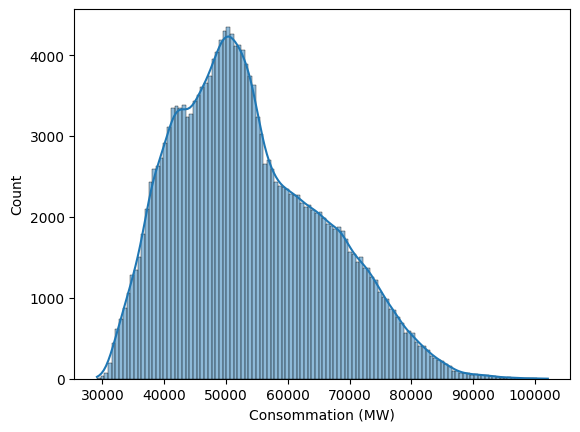

In [ ]:
# Describe the 'Consommation (MW)' column
print(df['Consommation (MW)'].describe())

# Plot the distribution of 'Consommation (MW)'
sns.histplot(df['Consommation (MW)'], kde=True)  # Replacing `sns.distplot` with `sns.histplot`, as `distplot` is deprecated.

# Perform a normality test
normal_test = stats.normaltest(df['Consommation (MW)'])
print(f'Normality test results: Statistic={normal_test.statistic}, p-value={normal_test.pvalue}')

# Kurtosis
kurtosis = stats.kurtosis(df['Consommation (MW)'])
print(f'Kurtosis of normal distribution (should be 0): {kurtosis}')

# Skewness

skewness = stats.skew(df['Consommation (MW)'])
print(f'Skewness of normal distribution (should be 0): {skewness}')


Interpretation of Kurtosis for Energy Consumption:

kurtosis < 0: Low kurtosis suggests the consumption values are concentrated near the mean, with few extremes.


Interpretation of Skewness for Energy Consumption:

we got 0.5 means he distribution is almost balanced with unusually high energy consumption.



# Time series Plot :

In [6]:
# Select the relevant columns: 'Time' and 'Consommation (MW)'
df1 = df.loc[:, ['Time', 'Consommation (MW)']]

# Ensure the 'Time' column is in datetime format
df1['Time'] = pd.to_datetime(df1['Time'])

# Set 'Time' as the index
df1.set_index('Time', inplace=True)

# Display the first few rows to verify
print(df1.head())


                     Consommation (MW)
Time                                  
2012-01-01 00:00:00            58315.0
2012-01-01 00:30:00            58315.0
2012-01-01 01:00:00            56231.0
2012-01-01 01:30:00            56075.0
2012-01-01 02:00:00            55532.0


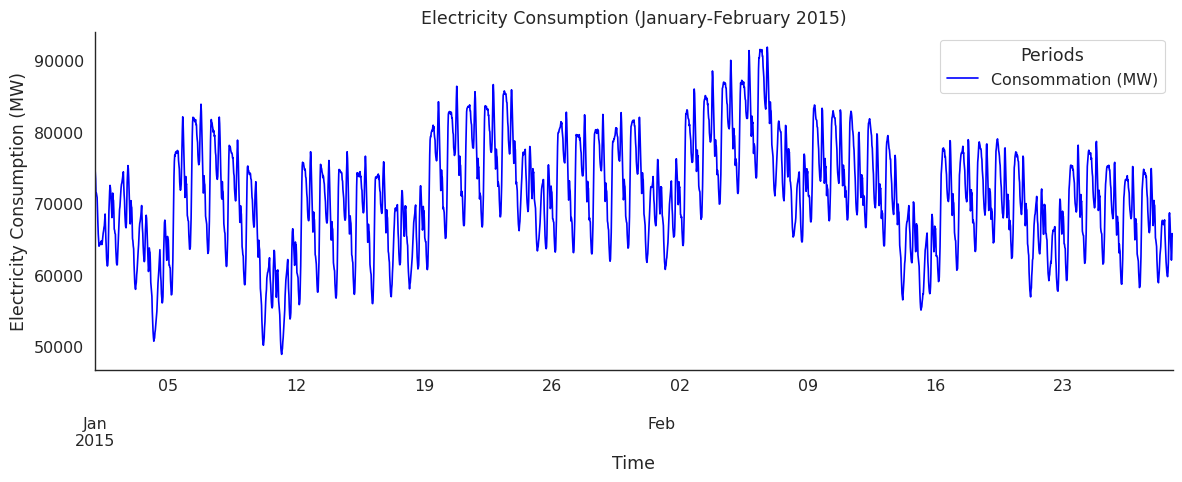

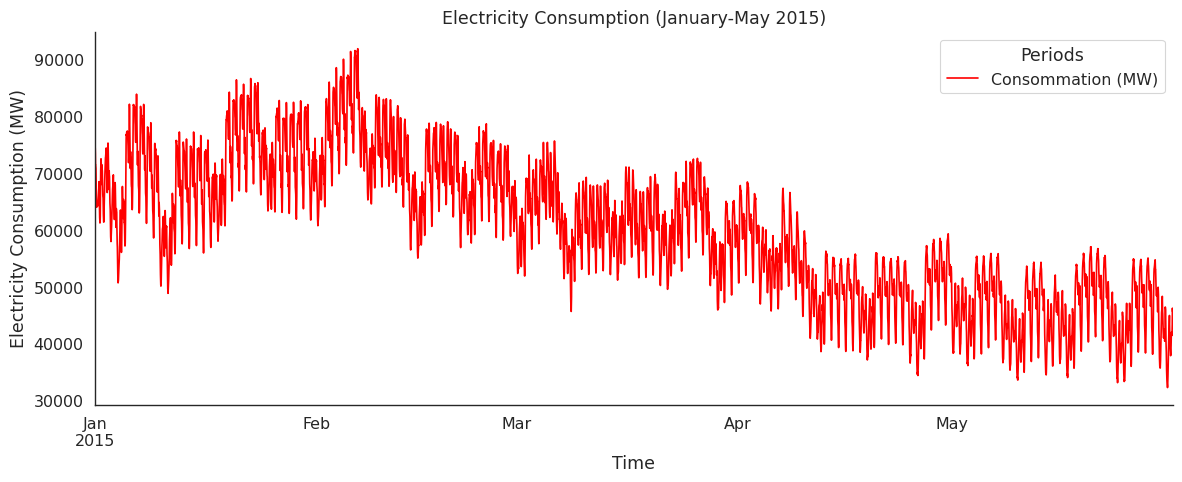

In [7]:
df2=df1[(df1.index>='2015-01-01') & (df1.index<'2015-03-01')]
df3=df1[(df1.index>='2015-01-01') & (df1.index<'2015-06-01')]
#a=plt.figure(figsize=(15,6))
#sns.set_style("whitegrid", {'axes.grid' : False});


# Set Seaborn style and context
sns.set_style('white')
sns.set_context("paper", font_scale=1.3)

# Plot df2 on the first figure
fig1, ax1 = plt.subplots(figsize=(12, 5))
df2.plot(ax=ax1, label="January-February 2015", color="blue")
ax1.set_title("Electricity Consumption (January-February 2015)")
ax1.set_ylabel("Electricity Consumption (MW)")
ax1.set_xlabel("Time")
ax1.legend(title="Periods")
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig('Electricity_Consumption_Jan-Feb_2015.png', dpi=400)
plt.show()

# Plot df3 on the second figure
fig2, ax2 = plt.subplots(figsize=(12, 5))
df3.plot(ax=ax2, label="January-May 2015", color="RED")
ax2.set_title("Electricity Consumption (January-May 2015)")
ax2.set_ylabel("Electricity Consumption (MW)")
ax2.set_xlabel("Time")
ax2.legend(title="Periods")
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig('Electricity_Consumption_Jan-May_2015.png', dpi=400)
plt.show()


The first plot shows a clear cyclic or periodic pattern in the data, with peaks and troughs occurring regularly this represent daily consumption variations, where demand is higher during certain hours (e.g., daytime) and lower during others (e.g., nighttime)

The second plot shows a clear cyclic pattern with a noticeable declining trend in electricity consumption over time. Starting in January 2015, the consumption appears to decrease steadily toward May 2015.

In [8]:
q = df["Consommation (MW)"].quantile(0.97)
dfq=df[df["Consommation (MW)"] < q]

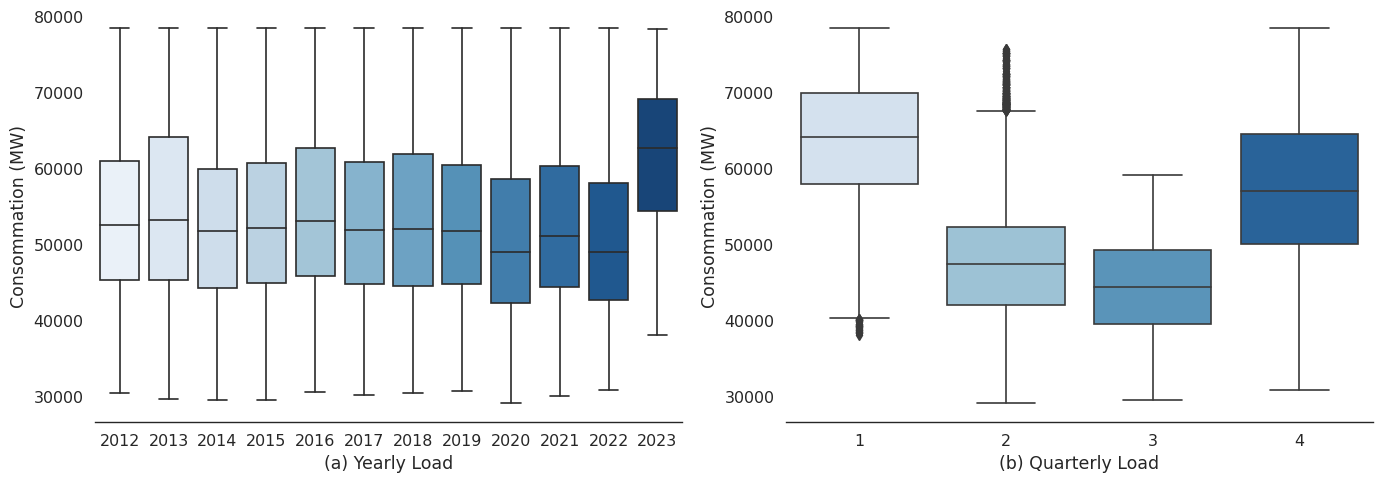

In [9]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.3)
a=plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Consommation (MW)", data=dfq, palette='Blues');
plt.xlabel('(a) Yearly Load')
sns.despine(left=True);
plt.tight_layout()

plt.subplot(1,2,2)

sns.boxplot(x="quarter", y="Consommation (MW)", data=dfq, palette='Blues');
plt.xlabel('(b) Quarterly Load')
sns.despine(left=True);
plt.tight_layout()

#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
plt.savefig('Fig2.png', dpi=300)

# Electricty Consumption Distribution

,count,mean,std,min,25%,50%,75%,max
Consommation (MW),194352.00,53837.22,11997.60,29124.00,44705.00,52086.00,62056.00,102098.00


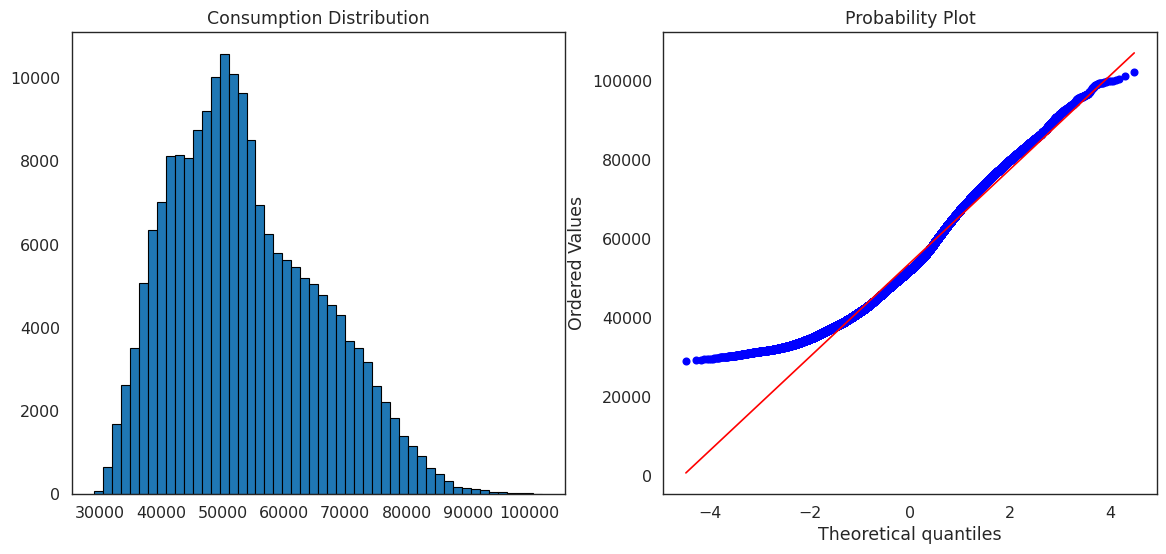

In [10]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Consommation (MW)'].hist(bins=50,edgecolor='black', grid=False)
plt.title('Consumption Distribution')

plt.subplot(1,2,2)
stats.probplot(df['Consommation (MW)'], plot=plt);
#print("Skewness: %f" % df['Consumption'].skew())
#print("Kurtosis: %f" % df['Consumption'].kurt())
df1.describe().transpose()

Coment:We can see that the dataset is approcimatly normally distributed.

# Consumption by Year, Quarter, Month and Day

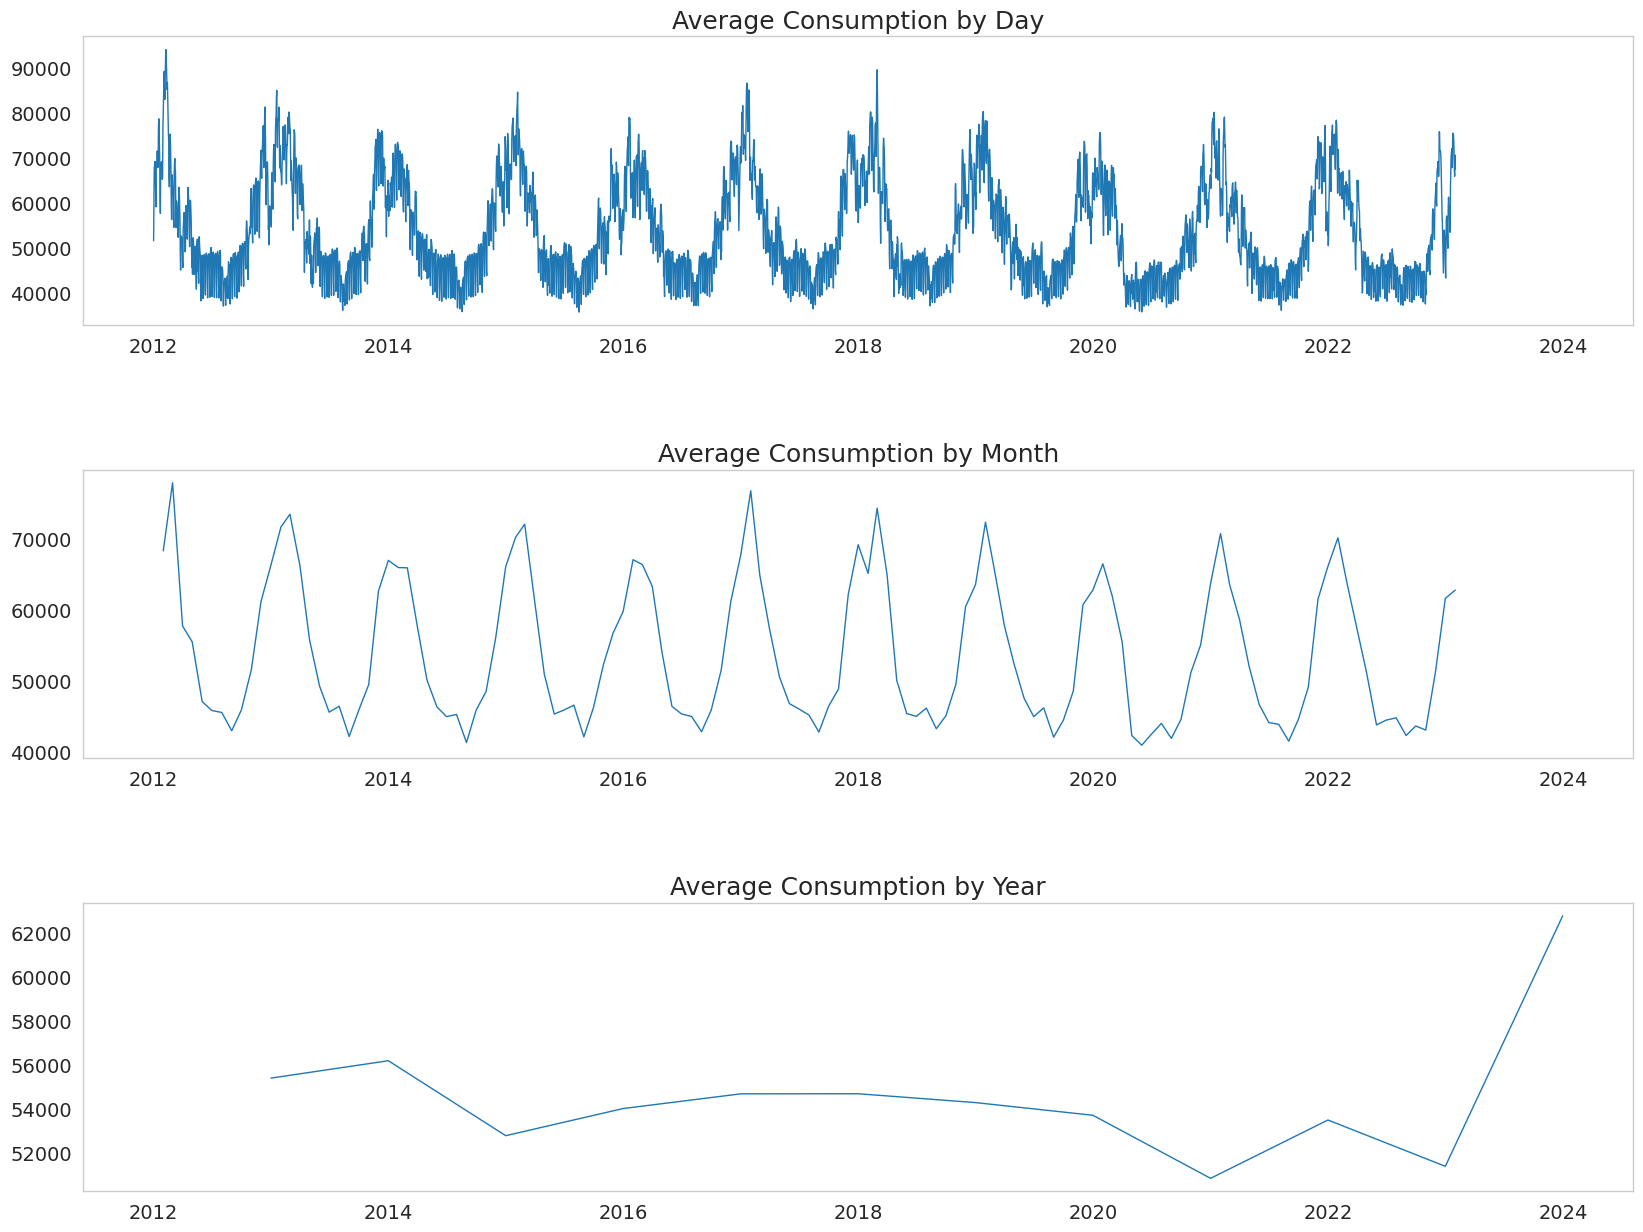

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=.5)
ax1 = fig.add_subplot(3,1,1)
ax1.plot(df1['Consommation (MW)'].resample('D').mean(),linewidth=1)
ax1.set_title('Average Consumption by Day', fontsize=18)
#ax1.set_ylabel('Average Consumption', fontsize=14)
#ax1.set_xlabel('Day of Crime', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=14)

ax2 = fig.add_subplot(3,1,2, sharex=ax1)
ax2.plot(df1['Consommation (MW)'].resample('M').mean(),linewidth=1)
ax2.set_title('Average Consumption by Month', fontsize=18)
#ax2.set_ylabel('# of Crimes', fontsize=14)
#ax2.set_xlabel('Month of Crime', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

ax3  = fig.add_subplot(3,1,3, sharex=ax1)
ax3.plot(df1['Consommation (MW)'].resample('A').mean(),linewidth=1)
ax3.set_title('Average Consumption by Year', fontsize=18)
#ax3.set_ylabel('# of Crimes', fontsize=14)
#ax3.set_xlabel('Year of Crime', fontsize=14)
ax3.tick_params(axis='both', which='major', labelsize=14)

The data shows strong seasonality and short-term fluctuations but lacks a long-term trend.

Since there is no clear upward or downward trend, applying regression or drawing a straight trend line would not accurately predict the long-term behavior of the data.


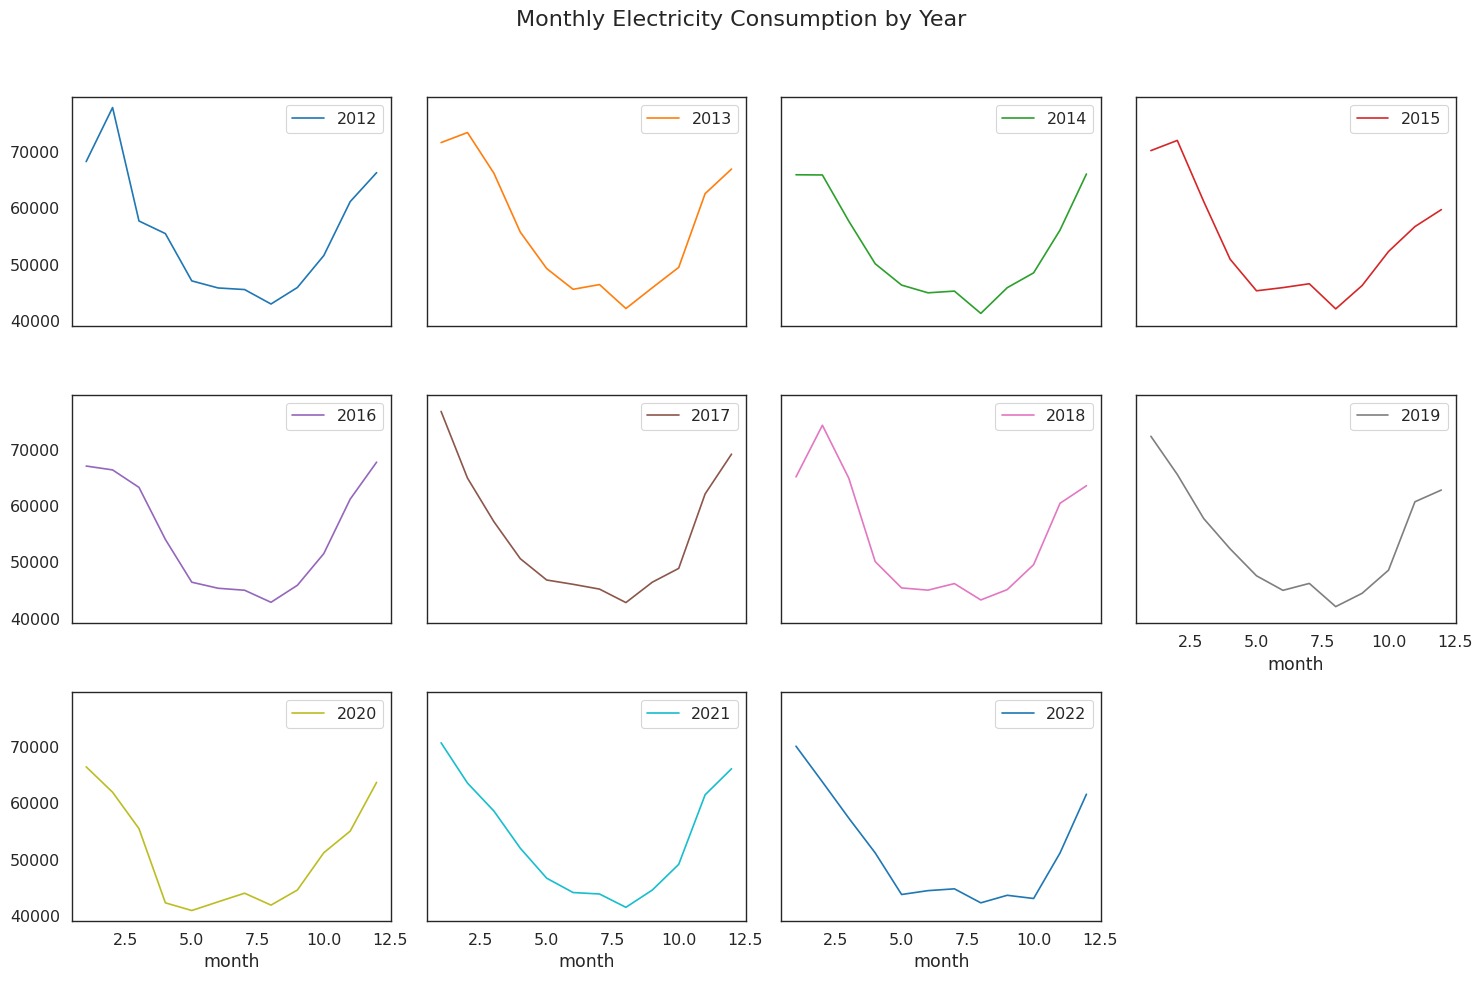

In [11]:
df_filtered = df[df['year'] != 2023]

# Create a pivot table for "Consommation (MW)" by year and month, excluding 2023
dfPivot = pd.pivot_table(df_filtered, values="Consommation (MW)",
                         columns="year", index="month")

# Plot the pivot table with subplots for each year
dfPivot.plot(subplots=True, figsize=(15, 10), layout=(3, 4), sharey=True, legend=True)

# Add a super title to the entire figure
plt.suptitle("Monthly Electricity Consumption by Year", fontsize=16)

# Adjust layout to avoid overlapping
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the super title

# Show the plots
plt.show()

/tmp/ipykernel_23/1008405178.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfq['Day'] = dfq['weekday'].map(dic)  # Assuming 'weekday' column exists (0 for weekday, 1 for weekend)


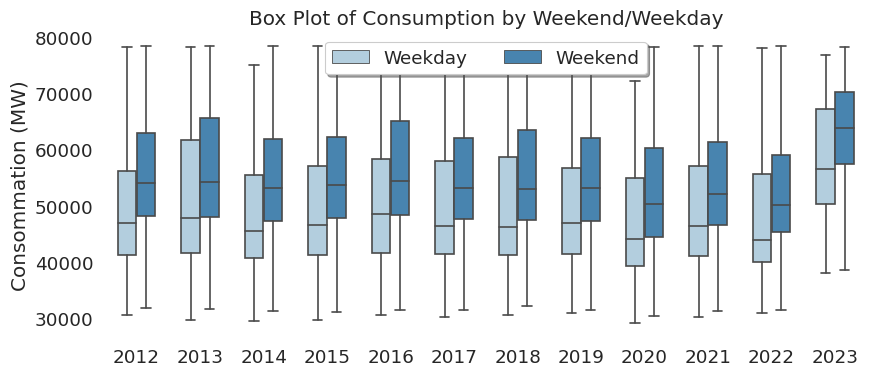

In [10]:
# Calculate the 97th percentile of "Consommation (MW)"
q = df["Consommation (MW)"].quantile(0.97)

# Filter the DataFrame to exclude values above the 97th percentile
dfq = df[df["Consommation (MW)"] < q]

# Create a mapping dictionary for weekday/weekend
dic = {0: 'Weekday', 1: 'Weekend'}

# Map the weekday/weekend information to a new column
dfq['Day'] = dfq['weekday'].map(dic)  # Assuming 'weekday' column exists (0 for weekday, 1 for weekend)

# Create the boxplot
a = plt.figure(figsize=(9, 4))
sns.set_context("paper", font_scale=1.5)

# Generate a boxplot grouped by year and 'Day' (Weekday/Weekend)
plt1 = sns.boxplot(
    x='year',
    y='Consommation (MW)',
    hue='Day',
    width=0.6,
    fliersize=3,
    data=dfq,
    palette='Blues'
)

# Customize the plot
plt.title('Box Plot of Consumption by Weekend/Weekday')
sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)

# Save the plot as an image
plt.savefig('Fig3.png', dpi=300)

# Show the plot
plt.show()


In [ ]:
df.head()

,Time,Consommation (MW),year,quarter,month,day,weekday
0,2012-01-01 00:00:00,58315.00,2012,1,1,1,0
1,2012-01-01 00:30:00,58315.00,2012,1,1,1,0
2,2012-01-01 01:00:00,56231.00,2012,1,1,1,0
3,2012-01-01 01:30:00,56075.00,2012,1,1,1,0
4,2012-01-01 02:00:00,55532.00,2012,1,1,1,0


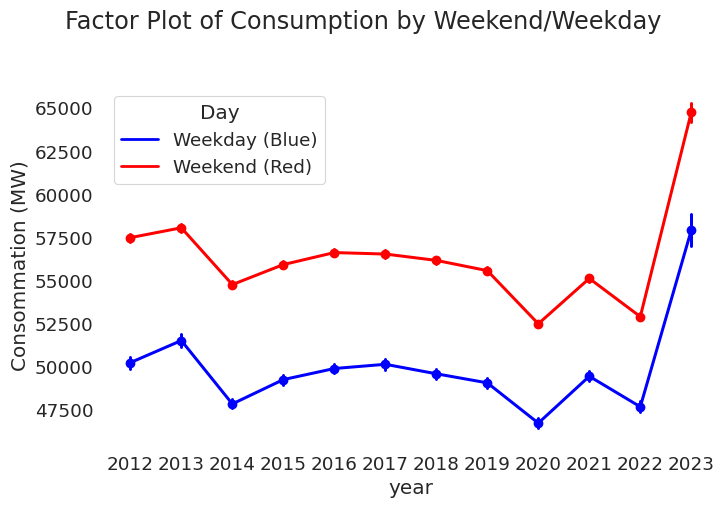

In [11]:
dic = {0: 'Weekday', 1: 'Weekend'}
df['Day'] = df['weekday'].map(dic)

sns.set_context("paper", font_scale=1.5)

# Define custom color palette for weekdays (blue) and weekends (red)
custom_palette = {'Weekday': 'blue', 'Weekend': 'red'}

# Create the point plot with a custom palette
plt1 = sns.catplot(
    x='year',
    y='Consommation (MW)',
    hue='Day',
    data=df,
    kind='point',
    height=5,
    aspect=1.5,
    palette=custom_palette,  # Custom palette
    legend=False
)

# Add title and customize layout
plt1.fig.suptitle('Factor Plot of Consumption by Weekend/Weekday', y=1.02)  # Adjust title position
sns.despine(left=True, bottom=True)

# Add legend with explicit color alignment
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='blue', lw=2, label='Weekday (Blue)'),
    Line2D([0], [0], color='red', lw=2, label='Weekend (Red)')
]
plt1.ax.legend(handles=custom_lines, loc='upper left', title='Day')

plt.tight_layout()

# Show the plot
plt.show()


# Dickey-Fuller test

In [ ]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()

    # Plot rolling statistics
    plt.figure(figsize=(14, 5))
    sns.despine(left=True)
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test
    print('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

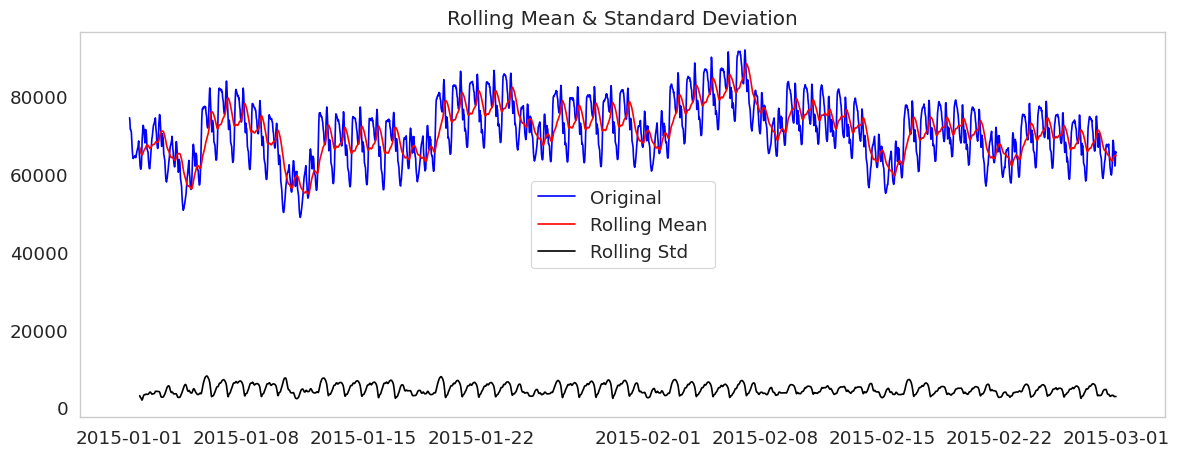

<Results of Dickey-Fuller Test>
Test Statistic                  -5.47
p-value                          0.00
#Lags Used                      28.00
Number of Observations Used   2803.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [ ]:
test_stationarity(df2["Consommation (MW)"])

# Checking Autocorrelation:

In [14]:
x= df["Consommation (MW)"]
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range =(0 , 1))
x = np. array (x). reshape (( len(x), ))
x=np.log (x)
print (x.shape)#x is a 1 dimensional array with 157786 rows
x=x.reshape(-1 ,1)
print (x.shape)
x = scaler.fit_transform(x)
x=x.reshape (-1)
print (x.shape)
print(round(x.min(),2))
print(round(x.max(),2))
from statsmodels.tsa.stattools import pacf
x_pacf=pacf (x,nlags=20, method='ols')
print (x_pacf)

(194352,)
(194352, 1)
(194352,)
0.0
1.0
[ 1.          0.99386068 -0.70553508  0.01932287  0.14838471  0.05952671
 -0.1248041  -0.00260165  0.0804086   0.07542438  0.05407978  0.01715067
  0.1466923   0.05672663 -0.10726099  0.1143049   0.08563414  0.15440244
 -0.07773699  0.11889082 -0.05369216]


# Log Transformation and First Difference:

In [ ]:
tslog=np.log(df1)
#tslog = tslog - tslog.shift(1)
#tslog=tslog+10
tslog.dropna(inplace=True)
negative_values_count = tslog[tslog["Consommation (MW)"] < 0].count()

print(negative_values_count)

Consommation (MW)    0
dtype: int64


# Post Dickey-Fuller Test:

In [12]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test
    print('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

# Log transformation (ensure no zero or negative values before applying log)
df1["Consommation (MW)"] = df1["Consommation (MW)"] + 1  # Add 1 to avoid log(0)
tslog = np.log(df1)

# Drop any NaN values
tslog.dropna(inplace=True)

# Run the Dickey-Fuller test on the transformed series
test_stationarity(tslog["Consommation (MW)"])

<Results of Dickey-Fuller Test>
Test Statistic                -1.348037e+01
p-value                        3.250128e-25
#Lags Used                     8.000000e+01
Number of Observations Used    1.942710e+05
Critical Value (1%)           -3.430384e+00
Critical Value (5%)           -2.861555e+00
Critical Value (10%)          -2.566778e+00
dtype: float64


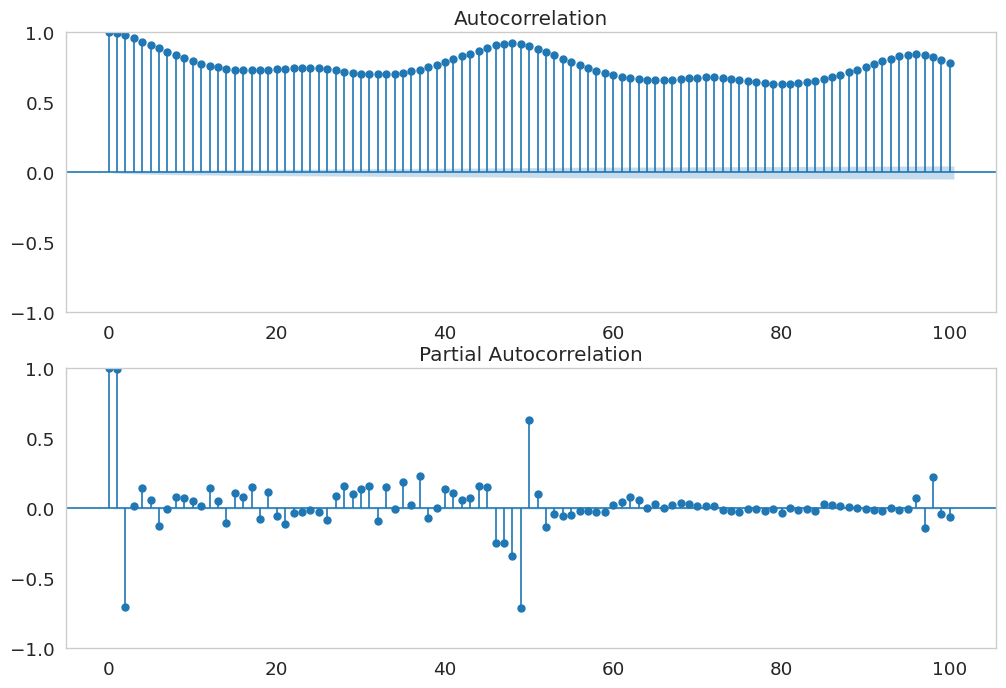

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(tslog.iloc[13:], lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(tslog.iloc[13:], lags=100, ax=ax2)

# Comment:

*   Strong Initial Autocorrelation (Lag 0 to 20) hence it is highly dependent on its recent values
*   Periodic Pattern (Wave-Like Behavior) which indicates the presence of seasonality or periodic behavior (in this exemple between 2 ofr exemple).

*   Significant Correlation Beyond the Confidence Interval because Many lags fall outside the confidence interval, confirming that the series has significant autocorrelation.





# Correlation:

In [14]:
dfc = df.copy()
for obs in range(1, 10):
    dfc["T_" + str(obs)] = dfc["Consommation (MW)"].shift(obs)


In [ ]:
dfc.head()

,Time,Consommation (MW),year,quarter,month,day,weekday,Day,T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9
0,2012-01-01 00:00:00,58315.00,2012,1,1,1,0,Weekday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-01 00:30:00,58315.00,2012,1,1,1,0,Weekday,58315.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-01 01:00:00,56231.00,2012,1,1,1,0,Weekday,58315.00,58315.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-01 01:30:00,56075.00,2012,1,1,1,0,Weekday,56231.00,58315.00,58315.00,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-01 02:00:00,55532.00,2012,1,1,1,0,Weekday,56075.00,56231.00,58315.00,58315.00,NaN,NaN,NaN,NaN,NaN


In [15]:
# Map 'Weekday' and 'Weekend' to numeric values
categorical_columns = dfc.select_dtypes(include=['object', 'category']).columns
# Encode the categorical columns
for col in categorical_columns:
    if col == 'Day':  # Example for 'Weekend'/'Weekday'
        mapping = {'Weekday': 0, 'Weekend': 1}
        dfc[col] = dfc[col].map(mapping)
    else:
        # One-hot encode other categorical columns
        dfc = pd.get_dummies(dfc, columns=[col], drop_first=True)
dfc.fillna(0.00,inplace=True)
dfc.head()

,Time,Consommation (MW),year,quarter,month,day,weekday,Day,T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9
0,2012-01-01 00:00:00,58315.0,2012,1,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-01-01 00:30:00,58315.0,2012,1,1,1,0,0,58315.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-01-01 01:00:00,56231.0,2012,1,1,1,0,0,58315.0,58315.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-01-01 01:30:00,56075.0,2012,1,1,1,0,0,56231.0,58315.0,58315.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-01-01 02:00:00,55532.0,2012,1,1,1,0,0,56075.0,56231.0,58315.0,58315.0,0.0,0.0,0.0,0.0,0.0


# Correlation Matrix:

In [16]:
a=pd.DataFrame(dfc.corr())
a;
columns_to_drop = ['year', 'quarter', 'month', 'day', 'weekday']
dfc.drop(columns=columns_to_drop, inplace=True)


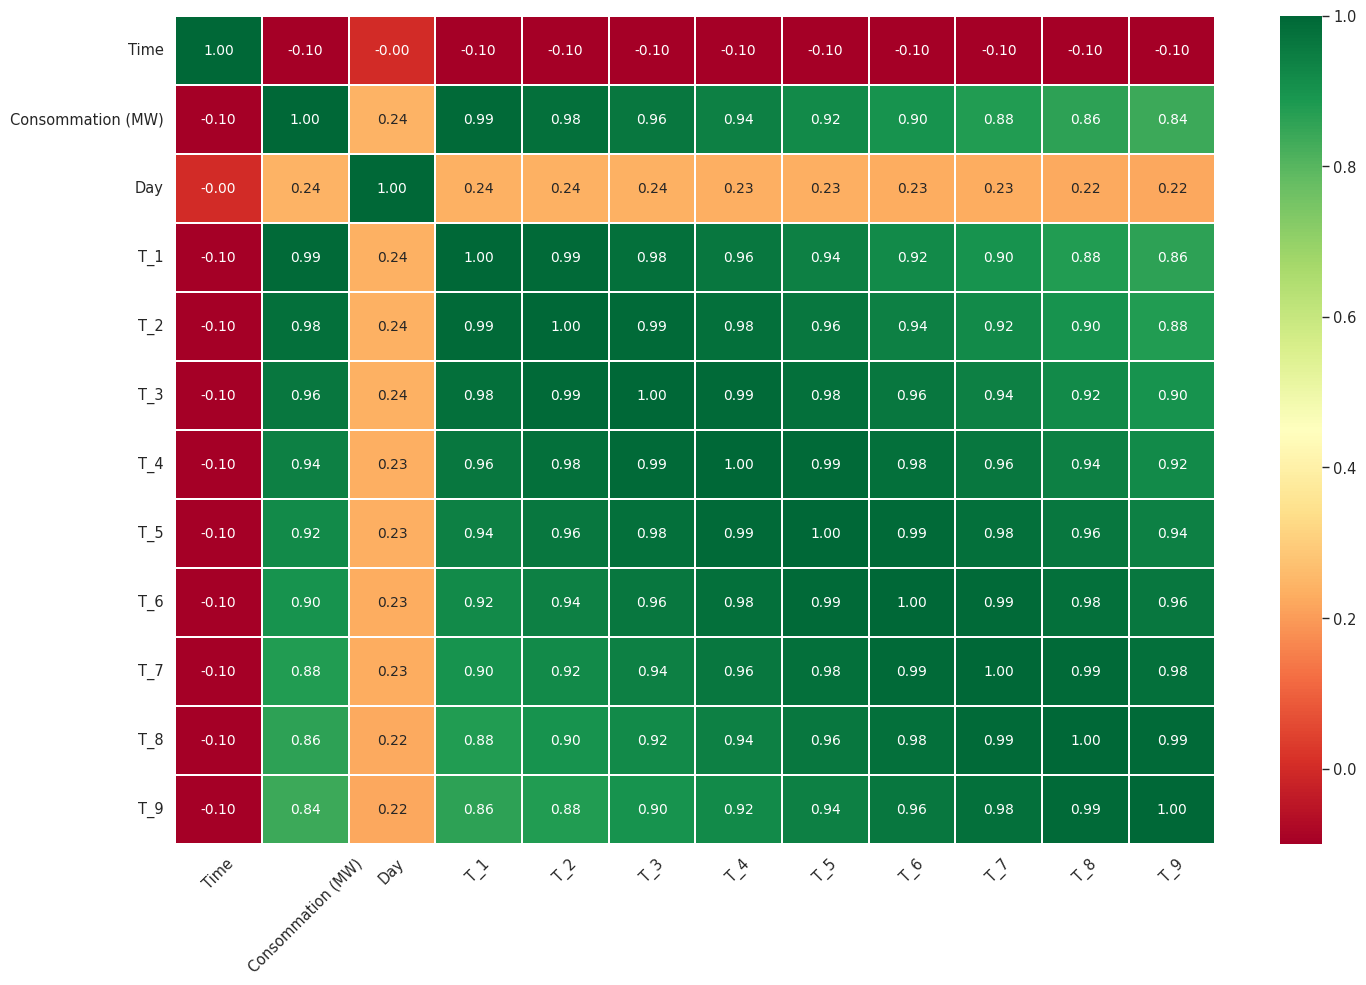

In [ ]:
# Set style and context
sns.set_style('white')
sns.set_context("paper", font_scale=1.2)

# Set figure size
plt.figure(figsize=(15, 10))

# Plot the heatmap
sns.heatmap(dfc.corr(),
            annot=True,          # Show correlation coefficients
            cmap='RdYlGn',       # Use diverging colormap
            linewidths=0.1,      # Add lines between cells
            fmt=".2f",           # Format numbers with 2 decimal places
            annot_kws={"size": 10})  # Adjust annotation font size
# Rotate axis labels
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Adjust layout for better display
plt.tight_layout()

plt.show()


In [17]:
dfc = df.copy()
for obs in range(1, 10):
    dfc["T_" + str(obs)] = dfc["Consommation (MW)"].shift(obs)

In [18]:
dfc = df.copy()
for obs in range(1, 10):
    dfc["T_" + str(obs)] = dfc["Consommation (MW)"].shift(obs)
dfc.head()

,Time,Consommation (MW),year,quarter,month,day,weekday,Day,T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9
0,2012-01-01 00:00:00,58315.0,2012,1,1,1,0,Weekday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-01 00:30:00,58315.0,2012,1,1,1,0,Weekday,58315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-01-01 01:00:00,56231.0,2012,1,1,1,0,Weekday,58315.0,58315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-01-01 01:30:00,56075.0,2012,1,1,1,0,Weekday,56231.0,58315.0,58315.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-01-01 02:00:00,55532.0,2012,1,1,1,0,Weekday,56075.0,56231.0,58315.0,58315.0,NaN,NaN,NaN,NaN,NaN


# Train Test Split

In [19]:
dfc.index.max()

194351

In [20]:
# Check for non-numeric columns
non_numeric_columns = dfc.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_columns)

# Handle missing values
dfc.fillna(0.00, inplace=True)  # Replace NaN with 0.00

# Verify that all columns are now numeric
print(dfc.dtypes)


Non-numeric columns: Index(['Time', 'Day'], dtype='object')
Time                 datetime64[ns]
Consommation (MW)           float64
year                          int32
quarter                       int32
month                         int32
day                           int32
weekday                       int64
Day                          object
T_1                         float64
T_2                         float64
T_3                         float64
T_4                         float64
T_5                         float64
T_6                         float64
T_7                         float64
T_8                         float64
T_9                         float64
dtype: object


In [21]:
print(dfc.columns)
dfc.head(20)

Index(['Time', 'Consommation (MW)', 'year', 'quarter', 'month', 'day',
       'weekday', 'Day', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 'T_6', 'T_7',
       'T_8', 'T_9'],
      dtype='object')


,Time,Consommation (MW),year,quarter,month,day,weekday,Day,T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9
0,2012-01-01 00:00:00,58315.0,2012,1,1,1,0,Weekday,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-01-01 00:30:00,58315.0,2012,1,1,1,0,Weekday,58315.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-01-01 01:00:00,56231.0,2012,1,1,1,0,Weekday,58315.0,58315.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-01-01 01:30:00,56075.0,2012,1,1,1,0,Weekday,56231.0,58315.0,58315.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-01-01 02:00:00,55532.0,2012,1,1,1,0,Weekday,56075.0,56231.0,58315.0,58315.0,0.0,0.0,0.0,0.0,0.0
5,2012-01-01 02:30:00,54911.0,2012,1,1,1,0,Weekday,55532.0,56075.0,56231.0,58315.0,58315.0,0.0,0.0,0.0,0.0
6,2012-01-01 03:00:00,52496.0,2012,1,1,1,0,Weekday,54911.0,55532.0,56075.0,56231.0,58315.0,58315.0,0.0,0.0,0.0
7,2012-01-01 03:30:00,50664.0,2012,1,1,1,0,Weekday,52496.0,54911.0,55532.0,56075.0,56231.0,58315.0,58315.0,0.0,0.0
8,2012-01-01 04:00:00,49161.0,2012,1,1,1,0,Weekday,50664.0,52496.0,54911.0,55532.0,56075.0,56231.0,58315.0,58315.0,0.0
9,2012-01-01 04:30:00,47596.0,2012,1,1,1,0,Weekday,49161.0,50664.0,52496.0,54911.0,55532.0,56075.0,56231.0,58315.0,58315.0


In [22]:
dfc['Time'] = pd.to_datetime(dfc['Time'])  # Convert 'Time' column to datetime
dfc.set_index('Time', inplace=True)       # Set 'Time' as index

In [23]:
# Identify the categorical columns in df
categorical_columns = dfc.select_dtypes(include=['object', 'category']).columns

# Encode the categorical columns
for col in categorical_columns:
    if col == 'Day':  # Example for 'Weekend'/'Weekday'
        mapping = {'Weekday': 0, 'Weekend': 1}
        dfc[col] = dfc[col].map(mapping)
    else:
        # One-hot encode other categorical columns
        dfc = pd.get_dummies(dfc, columns=[col], drop_first=True)

dfc = dfc.dropna()


# Define the training and testing ranges
train_start = '2012-01-01'
train_end = '2019-12-31'
test_start = '2020-01-01'
test_end = '2022-12-31'

In [24]:
# Split up into training and testing sets (still in Pandas dataframes)

X_train = dfc[train_start:train_end]
del X_train['Consommation (MW)']

y_train = dfc['Consommation (MW)'][train_start:train_end]

X_test = dfc[test_start:test_end]
del X_test['Consommation (MW)']

y_test = dfc['Consommation (MW)'][test_start:test_end]

In [28]:
X_train.head(100)

,year,quarter,month,day,weekday,Day,T_1,T_2,T_3,T_4,T_5,T_6,T_7,T_8,T_9
Time,,,,,,,,,,,,,,,
2012-01-01 00:00:00,2012,1,1,1,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2012-01-01 00:30:00,2012,1,1,1,0,0,58315.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2012-01-01 01:00:00,2012,1,1,1,0,0,58315.00,58315.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2012-01-01 01:30:00,2012,1,1,1,0,0,56231.00,58315.00,58315.00,0.00,0.00,0.00,0.00,0.00,0.00
2012-01-01 02:00:00,2012,1,1,1,0,0,56075.00,56231.00,58315.00,58315.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-01-02 23:30:00,2012,1,1,2,1,1,65929.00,64030.00,63756.00,65332.00,67435.00,69050.00,71079.00,72615.00,73263.00
2012-01-03 00:00:00,2012,1,1,3,1,1,64902.00,65929.00,64030.00,63756.00,65332.00,67435.00,69050.00,71079.00,72615.00
2012-01-03 00:30:00,2012,1,1,3,1,1,64600.00,64902.00,65929.00,64030.00,63756.00,65332.00,67435.00,69050.00,71079.00


In [25]:
print ('Number of observations in the Training set:', len(X_train))
print ('Percentage of data in Training set:', len(X_train)/len(df)*100)
print ('Number of observations in the Test set: ', len(X_test))
print ('Percentage of data in Test set:', len(X_test)/len(df)*100)

Number of observations in the Training set: 140256
Percentage of data in Training set: 72.16596690540874
Number of observations in the Test set:  52608
Percentage of data in Test set: 27.068411953568784


In [29]:
def MAPError(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((np.abs(y_true - y_pred)) / (y_true)) * 100

# Linear Regression as Benchmark Model

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Initialize and fit the model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# R^2 (coefficient of determination) regression score function
# Mean squared error regression loss

benchmark_model = LinearRegression() #object of class LinearRegression

start = time()
benchmark_model.fit(X_train, y_train) #Fit object to training set
end = time()
y_pred=benchmark_model.predict(X_test)
print("Classifier fitted in {:.2f} seconds".format(end-start))
print("Score on Training data : {:.2f}%".format(benchmark_model.score(X_train, y_train) * 100))
print("Score on Testing data : {:.2f}%".format(benchmark_model.score(X_test, y_test) * 100))

print("RMSE : {:.3f}".format(np.sqrt(np.mean((y_test - y_pred)**2))))
mae = mean_absolute_error(y_test, y_pred)
print('MAE: %f' % mae)
mape=MAPError(y_test, y_pred)
print('MAPE: %f' % mape)

Classifier fitted in 0.18 seconds
Score on Training data : 99.38%
Score on Testing data : 99.51%
RMSE : 804.269
MAE: 592.968014
MAPE: 1.172187


# Coefficent of the linear regression:

In [ ]:
pd.DataFrame(benchmark_model.coef_,X_train.columns,columns=['Coeff'])

,Coeff
year,-1.74
quarter,-22.51
month,-0.73
day,-0.18
weekday,40.18
Day,40.18
T_1,1.66
T_2,-0.55
T_3,-0.23
T_4,-0.07


# Recersive feature elimination:

In [ ]:
from sklearn import linear_model
from sklearn.feature_selection import RFE

if __name__ == "__main__":

    lr = linear_model.LinearRegression()

    rfe = RFE(estimator=lr, n_features_to_select=10)
    fit = rfe.fit(X_train, y_train)
    print("Features: {features}".format(features=X_train.columns))
    print("Num Features: {number_features}".format(number_features=fit.n_features_))
    print("Selected Features: {support}".format(support=fit.support_))
    print("Feature Ranking: {ranking}".format(ranking=fit.ranking_))

    selected_columns = [column for column, selected in zip(X_train.columns, fit.support_) if selected]
    print("Selected columns: {selected}".format(selected = selected_columns))

# Machine Learning Modeling

1.Ridge Regression

2.k-Nearest Neighbors

3.Random Forest Regressor

4.GradientBoostingRegressor

5.ExtraTreesRegressor

6.Neural Network

In [ ]:
# Function to fit the regressor and record performance metrics
def pipeline(reg, X_train, y_train, X_test, y_test, **kwargs):

    # Dictionary to hold properties of Models
    reg_props = {}

    # Initialize and fit the regressor, and time taken
    regressor = reg(**kwargs)
    start = time()
    regressor.fit(X_train, y_train)
    end = time()

    # Store the metrics for the regressor
    reg_props["name"] = reg.__name__
    reg_props["train_time"] = end - start
    reg_props["train_score"] = regressor.score(X_train, y_train)
    reg_props["test_score"] = regressor.score(X_test, y_test)
    reg_props["rmse"] = np.sqrt(mean_squared_error(y_test, regressor.predict(X_test)))
    reg_props["MAE"] = mean_absolute_error(y_test, regressor.predict(X_test))
    reg_props["MAPE"] = MAPError(y_test, regressor.predict(X_test))

    return reg_props

In [ ]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

# Function to execute each algorithm through the pipeline
def execute_pipeline():
    # Create the list of algorithms
    regressors = [
        Ridge,
        KNeighborsRegressor,
        RandomForestRegressor,
        GradientBoostingRegressor,
        MLPRegressor,
        ExtraTreesRegressor,
            ]

    # To store the properties for each regressor
    props = []

    """
    Iterate thorugh the list of regressors,
    passing each thorugh the pipeline and
    storing its properites
    """
    for reg in regressors:
        properites = pipeline(reg, X_train, y_train, X_test, y_test)
        props.append(properites)

    return props

Mean Absolute Deviation MAD:

The average of the absolute values of the devition between the actual and forecast. The absolute error is the absolute value of the difference between the forecasted value and the actual value. MAE tells us how big of an error we can expect from the forecast on average.

The MAPE (Mean Absolute Percent Error) measures the size of the error in percentage terms. MAPE allows us to compare forecasts of different series in different scales.

In [ ]:
def get_properties():
    # Obtain the properties after executing the pipeline
    properties = execute_pipeline()

    # Extract each individual property of the Regressors
    names = [prop["name"] for prop in properties]
    train_times = [prop["train_time"] for prop in properties]
    train_scores = [prop["train_score"] for prop in properties]
    test_scores = [prop["test_score"] for prop in properties]
    rmse_vals = [prop["rmse"] for prop in properties]
    mae_vals = [prop["MAE"] for prop in properties]
    mape_vals=[prop["MAPE"] for prop in properties]

    # Create a DataFrame from these properties
    df = pd.DataFrame(index=names,
                    data = {
                            "Training Times": train_times,
                            "Training Scores": train_scores,
                            "Testing Scores": test_scores,
                            "RMSE": rmse_vals,
                            "MAE":mae_vals,
                            "MAPE":mape_vals
                      }
                  )

    return df

# Obain the properties in a structured DataFrame after executing the pipeline
properties = get_properties()

In [ ]:
# Append the peoperties of Linear Rgression Benchmark model to the DataFrame
# Storing the properties of Selected models

properties = pd.concat(
    [properties,
    pd.Series(
    {
        "Name": "Linear Regression (Benchmark)",
        "RMSE": np.sqrt(mean_squared_error(y_test, benchmark_model.predict(X_test))),
        "MAE": mean_absolute_error(y_test, benchmark_model.predict(X_test)),
        "MAPE": MAPError(y_test, benchmark_model.predict(X_test)),
        "Training Scores": benchmark_model.score(X_train, y_train),
        "Testing Scores" :benchmark_model.score(X_test, y_test),
        "Training Times": end - start

    }
    ).to_frame().T.set_index(["Name"])]
)

properties

# Performance Plots of Models:

In [ ]:
# Plot to compare thePerformance of Algorithms
sns.set_context("notebook", font_scale=1.7)
plt.figure(figsize=(18,13))
plt.subplot(2,2,1)
plt.ylabel("RMSE OF Regressors")
properties["RMSE"].plot(kind="barh", color='#4d80b3');
sns.despine(left=True)
plt.tight_layout()


plt.subplot(2,2,2)
plt.ylabel("MAE OF Regressors")
properties["MAE"].plot(kind="barh", color='#4d80b3');
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,3)
plt.ylabel("MAPE OF Regressors")
properties["MAPE"].plot(kind="barh", color='#4d80b3');
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,4)
plt.ylabel("Training Time of Regressors")
properties["Training Times"].plot(kind="barh", color='#4d80b3');
sns.despine(left=True)
plt.tight_layout()

In [ ]:
# Plot to compare the performance of Models on both datasets
sns.set_style('white')
sns.set_context("paper", font_scale=1.3)

ax= properties[["MAE", "RMSE"]].plot(kind="barh", color=['#9491B5', '#685CF4'], title="Performance of Regressor", figsize=(10, 4))
sns.despine(left=True);
plt.tight_layout()
plt.savefig('book1.png', dpi=300)
plt.show()


# Hyper Parameter Tuning of Extra Trees Regressor:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize the best performing regressor
clf = ExtraTreesRegressor()

# Define the parameter subset
param_grid = {
    "n_estimators": [10, 50, 75, 100, 150],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [50, 100,150, 200, 250]
}
# Use Randomized search to try subsets from parameter space with cross-validation
grid_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_grid,
    n_iter=10,
    scoring="neg_mean_squared_error",  # Correct scoring metric
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

In [ ]:
#Display best params
print("Parameters of best Regressor : {}".format(grid_search.best_params_))

# Forecasting Metrics after Tuning:

In [ ]:
best_model = grid_search.best_estimator_
print('Mean Absolute Error:', mean_absolute_error(y_test, best_model.predict(X_test)))
print('Mean Squared Error:',np.sqrt(mean_squared_error(y_test, best_model.predict(X_test))))
print('Mean Absolute Percentage Error:',MAPError(y_test, best_model.predict(X_test)))

# GridSearch CV:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the model
clf = ExtraTreesRegressor()

# Define the parameter grid
param_grid = {
    "n_estimators": [10, 50, 75, 100, 150],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [50, 100, 150, 200, 250]
}

# Perform Grid Search with cross-validation
gs_cv = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # Use neg_mean_squared_error for regression
    cv=3,
    n_jobs=4
).fit(X_train, y_train)

# Display best hyperparameter setting
print("Parameters of best Regressor:", gs_cv.best_params_)

# Get the best model
best_model = gs_cv.best_estimator_

# Evaluate the best model
mae = mean_absolute_error(y_test, best_model.predict(X_test))
rmse = np.sqrt(mean_squared_error(y_test, best_model.predict(X_test)))



mape = MAPError(y_test, best_model.predict(X_test))

# Display metrics
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Percentage Error:", mape)


In [ ]:
testPredict1=pd.DataFrame(best_model.predict(X_test))
testY1=pd.DataFrame(y_test)
testY1=testY1.transpose()

sns.set_style('white')
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(14,6))
plt.plot(y_test[800:1600], label = "Test Data")
plt.plot(testPredict1[800:1600], label = "Test Predict")
plt.legend();

In [ ]:
from sklearn.metrics import mean_squared_error

def performance_metric(y_true, y_predict):
    """ Calculates and returns the total error between true and predicted values
        based on a performance metric chosen by the student. """


    error = mean_squared_error(y_true, y_predict)
    return error

In [ ]:
def learning_curves(X_train, y_train, X_test, y_test):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing error rates for each model are then plotted. """

    print ("Creating learning curve graphs for max_depths of 1, 3, 6, and 10. . .")

    # Create the figure window
    fig = plt.figure(figsize=(6,4))

    # We will vary the training set size so that we have 50 different sizes
    sizes = np.rint(np.linspace(1, len(X_train), 50)).astype(int)
    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))

    # Create four different models based on max_depth
    for k, depth in enumerate([150]):

        for i, s in enumerate(sizes):

            # Setup a decision tree regressor so that it learns a tree with max_depth = depth
            regressor = ExtraTreesRegressor(n_estimators=100, max_depth = depth)

            # Fit the learner to the training data
            regressor.fit(X_train[:s], y_train[:s])

            # Find the performance on the training set
            train_err[i] = performance_metric(y_train[:s], regressor.predict(X_train[:s]))

            # Find the performance on the testing set
            test_err[i] = performance_metric(y_test, regressor.predict(X_test))

        # Subplot the learning curve graph
        sns.set_style('white')
        sns.set_context("paper", font_scale=1.3)
        #ax = fig.add_subplot(2, 2, k+1)
        plt.plot(sizes, test_err, label = 'Testing Error')
        plt.plot(sizes, train_err, label = 'Training Error')
        plt.legend()
        #ax.set_title('max_depth = %s'%(depth))
        plt.xlabel('Number of Data Points')
        plt.ylabel('Mean Squared Error')
        plt.xlim([0, len(X_train)])

    # Visual aesthetics

    fig.tight_layout()
    sns.despine(left=True)
    fig.show()
    plt.savefig('Trees.jpeg', dpi=200)

In [ ]:
learning_curves(X_train, y_train, X_test, y_test)

# Feature Importance by the Tree Based Model:

In [ ]:
# Find the index of most and least important feature and display that column
print("Most important feature = {}".format(X_train.columns[np.argmax(best_model.feature_importances_)]))
print("Least important feature = {}".format(X_train.columns[np.argmin(best_model.feature_importances_)]))

# Get the indices based on feature importance in ascending order
feature_indices = np.argsort(best_model.feature_importances_)


In [ ]:
# Plot feature importance
fi = pd.DataFrame(index=X_train.columns[feature_indices], data=np.sort(best_model.feature_importances_))
fi.sort_values(by=0, ascending=False)
fi.head()
# Plot feature importance
fi = pd.DataFrame(index=X_train.columns[feature_indices], data=np.sort(best_model.feature_importances_))
fi.sort_values(by=0, ascending=False, inplace=True)
ax = fi.plot(kind="bar", title="Feature Importances", figsize=(16, 8))
ax.set_ylabel("Values", fontsize="large")
ax.legend_.remove()

## SARIMA

In [ ]:
!pip install pmdarima
!pip install git+https://github.com/statsmodels/statsmodels.git


import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm


In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Load and clean the dataset
dataframe = pd.read_csv('/kaggle/input/eco2mix-national-cons-def/eco2mix-national-cons-def.csv', delimiter=';')

# Select only numeric columns
numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns
filtered_dataset = dataframe[numeric_columns]

# Drop rows with missing or invalid data
filtered_dataset = filtered_dataset.dropna()

# Extract the target variable (assuming it's the first column)
target_column = filtered_dataset.columns[0]  # Replace with your target column name if different
time_series = filtered_dataset[target_column].values.astype('float32')

# Normalize the data
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
normalized_series = scaler.fit_transform(time_series.reshape(-1, 1)).flatten()

# Split into train and test sets
train_size = int(len(normalized_series) * 0.4)
train_series = normalized_series[:train_size]
test_series = normalized_series[train_size+1:]

# Inverse transform for SARIMA
scaled_train_series = scaler.inverse_transform(train_series.reshape(-1, 1)).flatten()
scaled_test_series = scaler.inverse_transform(test_series.reshape(-1, 1)).flatten()



/tmp/ipykernel_166/3172774407.py:8: DtypeWarning: Columns (23,28) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv('/kaggle/input/eco2mix-national-cons-def/eco2mix-national-cons-def.csv', delimiter=';')


In [3]:
# Fit SARIMA model
p, d, q = 1, 0, 1       # Non-seasonal parameters
P, D, Q, s = 1, 1, 1, 48  # Seasonal parameters (e.g., daily seasonality with hourly data)

sarima_model = SARIMAX(scaled_train_series, 
                       order=(p, d, q), 
                       seasonal_order=(P, D, Q, s), 
                       enforce_stationarity=False, 
                       enforce_invertibility=False)

sarima_results = sarima_model.fit()

# Print model summary
print(sarima_results.summary())



KeyboardInterrupt: 

In [ ]:
# Define the number of steps to forecast (e.g., a quarter of the train set)
forecast_steps = len(train_series) // 4

# Initialize a rolling forecast list
rolling_forecast = []

# Copy the train data (use this to simulate the rolling forecast scenario)
rolling_data = list(scaled_train_series)

for step in range(forecast_steps):
    # Fit SARIMA to the rolling data
    sarima_model = SARIMAX(rolling_data,
                           order=(p, d, q),
                           seasonal_order=(P, D, Q, s),
                           enforce_stationarity=False,
                           enforce_invertibility=False)
    
    sarima_results = sarima_model.fit(disp=False)
    
    # Forecast the next value
    forecast = sarima_results.forecast(steps=1)
    rolling_forecast.append(forecast[0])  # Append the forecast value
    
    # Add the forecast to the rolling dataset
    rolling_data.append(forecast[0])  # Use forecasted value for the next prediction

# Inverse transform the rolling forecast for comparison
rolling_forecast_scaled = scaler.transform(np.array(rolling_forecast).reshape(-1, 1)).flatten()

# Plot the rolling forecast against the original series
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(normalized_series)), normalized_series, label='Original Data', color='blue')
plt.plot(np.arange(len(train_series)), train_series, label='Train Data', color='green')
plt.plot(np.arange(len(train_series), len(train_series) + len(rolling_forecast_scaled)),
         rolling_forecast_scaled, label='Rolling SARIMA Forecast', color='red')
plt.legend()
plt.title('Rolling SARIMA Forecast vs Original Data')
plt.show()


Training size: 136046, Testing size: 58306


In [9]:
df = dataframe.dropna()
df.head(60)

,Périmètre,Nature,Date,Heure,Date et Heure,Consommation (MW),Prévision J-1 (MW),Prévision J (MW),Fioul (MW),Charbon (MW),...,Gaz - TAC (MW),Gaz - Cogénération (MW),Gaz - CCG (MW),Gaz - Autres (MW),Hydraulique - Fil de l'eau + éclusée (MW),Hydraulique - Lacs (MW),Hydraulique - STEP turbinage (MW),Bioénergies - Déchets (MW),Bioénergies - Biomasse (MW),Bioénergies - Biogaz (MW)
0,France,Données définitives,2014-01-11,22:00,2014-01-11T22:00:00+01:00,59447.0,59600,59200,275.0,1554.0,...,-1.0,1831.0,214.0,83.0,5934.0,2305.0,71.0,598.0,162.0,179.0
4,France,Données définitives,2014-01-12,04:30,2014-01-12T04:30:00+01:00,52109.0,51500,51300,275.0,-31.0,...,-2.0,1827.0,231.0,84.0,5036.0,725.0,0.0,597.0,162.0,180.0
12,France,Données définitives,2014-01-13,04:30,2014-01-13T04:30:00+01:00,52961.0,52400,52100,276.0,194.0,...,-2.0,1810.0,247.0,83.0,4754.0,976.0,0.0,569.0,158.0,174.0
15,France,Données définitives,2014-01-13,15:00,2014-01-13T15:00:00+01:00,68685.0,70200,67800,345.0,2722.0,...,-3.0,1909.0,385.0,83.0,5648.0,2735.0,540.0,564.0,162.0,173.0
16,France,Données définitives,2014-01-13,16:00,2014-01-13T16:00:00+01:00,67713.0,69200,66800,276.0,2864.0,...,-3.0,1923.0,493.0,83.0,5758.0,2951.0,503.0,543.0,165.0,180.0
18,France,Données définitives,2014-01-13,17:30,2014-01-13T17:30:00+01:00,69761.0,71700,69700,276.0,3401.0,...,-2.0,1960.0,597.0,83.0,6233.0,3627.0,1271.0,562.0,169.0,182.0
19,France,Données définitives,2014-01-13,23:30,2014-01-13T23:30:00+01:00,66431.0,66300,65700,278.0,2350.0,...,-4.0,1915.0,200.0,83.0,5807.0,1739.0,0.0,579.0,169.0,185.0
20,France,Données définitives,2014-01-14,01:00,2014-01-14T01:00:00+01:00,61958.0,60700,61000,279.0,2071.0,...,-3.0,1943.0,169.0,83.0,5493.0,1483.0,0.0,585.0,170.0,184.0
21,France,Données définitives,2014-01-14,02:30,2014-01-14T02:30:00+01:00,60770.0,59300,59800,277.0,2030.0,...,-4.0,1936.0,203.0,83.0,5323.0,1775.0,0.0,579.0,165.0,180.0
23,France,Données définitives,2014-01-14,05:00,2014-01-14T05:00:00+01:00,57510.0,56900,57300,279.0,2121.0,...,-3.0,1933.0,269.0,83.0,5171.0,1102.0,0.0,577.0,158.0,181.0


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15475D+00    |proj g|=  9.32963D-03


 This problem is unconstrained.



At iterate    5    f=  8.15354D+00    |proj g|=  9.72087D-04

At iterate   10    f=  7.97572D+00    |proj g|=  2.02260D-01

At iterate   15    f=  7.68332D+00    |proj g|=  2.29629D-01

At iterate   20    f=  7.65339D+00    |proj g|=  9.20787D-03

At iterate   25    f=  7.65272D+00    |proj g|=  7.60191D-05

At iterate   30    f=  7.65271D+00    |proj g|=  7.50826D-04

At iterate   35    f=  7.65241D+00    |proj g|=  3.21479D-02

At iterate   40    f=  7.65231D+00    |proj g|=  8.73312D-03

At iterate   45    f=  7.65209D+00    |proj g|=  7.52564D-02

At iterate   50    f=  7.65198D+00    |proj g|=  2.91500D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


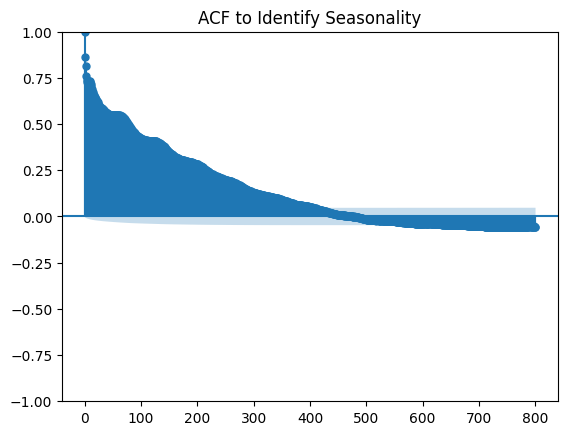

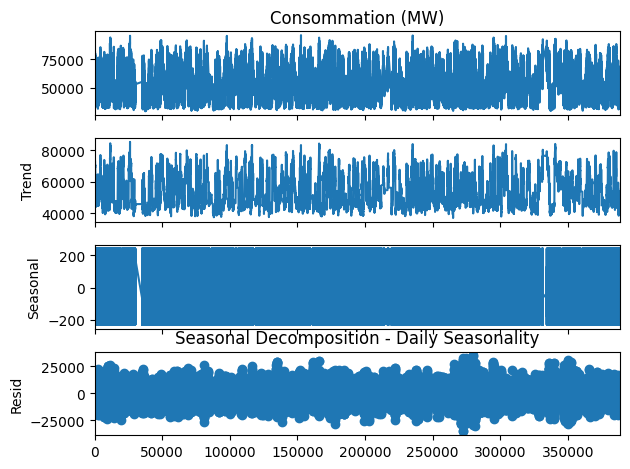

In [16]:
# Example of autocorrelation to check seasonality
from statsmodels.graphics.tsaplots import plot_acf

# Daily seasonality: Check lag up to 48
plot_acf(df['Consommation (MW)'], lags=800)  # Adjust lags for larger periods
plt.title('ACF to Identify Seasonality')
plt.show()

# Seasonal decomposition for daily seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Consommation (MW)'], period=48, model='additive')  # Daily
result.plot()
plt.title('Seasonal Decomposition - Daily Seasonality')
plt.show()


In [12]:
dataframe['Consommation (MW)']

0         59447.0
1             NaN
2             NaN
3             NaN
4         52109.0
           ...   
388699    45974.0
388700    44276.0
388701    42373.0
388702    41943.0
388703    41564.0
Name: Consommation (MW), Length: 388704, dtype: float64

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  dates : array_like, optional
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  dates : array_like, optional
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  dates : array_like, optional
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  dates : array_like, optional
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30min will be used.
  date

Best Parameters: (2, 1, 2), AIC: 3199562.950773756


 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3510651.671, Time=7.53 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=83.87 sec


KeyboardInterrupt: 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2326126.120, Time=10.82 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2413191.965, Time=2.20 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2322378.696, Time=28.31 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2348604.601, Time=66.57 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2413189.966, Time=1.12 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2326260.382, Time=6.46 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2322375.856, Time=98.33 sec


# LSTM Torch + GA

In [2]:
!pip install bitstring
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.7/71.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 10.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error
from deap import base, creator, tools, algorithms
# from bitstring import BitArray
from torch.utils.data import TensorDataset, DataLoader
from scipy.stats import bernoulli
from sklearn import preprocessing

In [3]:
# Load and clean the dataset
# dataframe = pd.read_csv('/content/drive/MyDrive/Time series project/eco2mix-national-cons-def.csv', delimiter=';')
dataframe = pd.read_csv('/kaggle/input/eco2mix-national-cons-def/eco2mix-national-cons-def.csv', delimiter=';')

# Select only numeric columns
numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns
filtered_dataset = dataframe[numeric_columns]

# Drop rows with missing or invalid data
filtered_dataset = filtered_dataset.dropna()

# Convert to numpy array
dataset = filtered_dataset.values

# Convert to float32
dataset = dataset.astype('float32')

# Normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.75)  
train = dataset[:train_size]
test = dataset[train_size+1:]
# Now proceed with the rest of your LSTM implementation



/tmp/ipykernel_23/2483111976.py:3: DtypeWarning: Columns (23,28) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv('/kaggle/input/eco2mix-national-cons-def/eco2mix-national-cons-def.csv', delimiter=';')


### Genetic

In [4]:



# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Create the Dataset
def create_dataset(data, look_back):
    dataX, dataY = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)



Using device: cuda


In [5]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=20, n_layers=1):
        super(LSTMModel, self).__init__()
        if n_layers == 1:
            self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        elif n_layers == 2:
            self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
            self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        else:
            raise ValueError("Only 1 or 2 LSTM layers are supported")
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.Linear(60, 50),
            nn.ReLU(),
            nn.Linear(50, 1)
        )
        self.n_layers = n_layers

    def forward(self, x):
        if self.n_layers == 1:
            _, (hn, _) = self.lstm(x)
            out = self.fc(hn[-1])
        elif self.n_layers == 2:
            out, _ = self.lstm1(x)
            out, _ = self.lstm2(out)
            out = self.fc(out[:, -1, :])
        return out


In [ ]:


# GA fitness evaluation
def train_evaluate(ga_individual_solution):
    # Decode GA solution
    lookback_bits = BitArray(ga_individual_solution[:6])
    hidden_size_bits = BitArray(ga_individual_solution[6:10])
    n_layers_bits = BitArray(ga_individual_solution[10:])
    
    lookback = max(lookback_bits.uint, 5)
    hidden_size = max(hidden_size_bits.uint, 10)
    n_layers = min(n_layers_bits.uint + 1, 2)

    print(f"Lookback: {lookback}, Hidden Size: {hidden_size}, Layers: {n_layers}")

    # Prepare dataset
    trainX, trainY = create_dataset(train, lookback)
    testX, testY = create_dataset(test, lookback)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    trainX = torch.tensor(trainX, dtype=torch.float32).to(device)
    trainY = torch.tensor(trainY, dtype=torch.float32).to(device)
    testX = torch.tensor(testX, dtype=torch.float32).to(device)
    testY = torch.tensor(testY, dtype=torch.float32).to(device)

    train_dataset = TensorDataset(trainX, trainY)
    train_loader = DataLoader(train_dataset, batch_size=132, shuffle=True)
    val_dataset = TensorDataset(testX, testY)
    val_loader = DataLoader(val_dataset, batch_size=132, shuffle=False)

    # Model setup
    model = LSTMModel(input_size=lookback, hidden_size=hidden_size, n_layers=n_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Training loop
    model.train()
    for epoch in range(20):  # Short training for GA evaluation
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss:.6f}")
    return val_loss,


In [ ]:

# Genetic Algorithm Setup
population_size = 10
num_generations = 5
gene_length = 11  # 6 for lookback, 4 for hidden size, 1 for layers

creator.create('FitnessMin', base.Fitness, weights=(-1.0,))
creator.create('Individual', list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n=gene_length)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.1)
toolbox.register('select', tools.selTournament, tournsize=3)
toolbox.register('evaluate', train_evaluate)

# Run Genetic Algorithm
population = toolbox.population(n=population_size)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, verbose=True)

# Decode the best individual
best_individual = tools.selBest(population, k=1)[0]
print("Best Individual:", best_individual)

# Decode parameters
lookback = max(BitArray(best_individual[:6]).uint, 5)
hidden_size = max(BitArray(best_individual[6:10]).uint, 10)
n_layers = min(BitArray(best_individual[10:]).uint + 1, 2)
print(f"Best Lookback: {lookback}, Best Hidden Size: {hidden_size}, Best Layers: {n_layers}")


### Genetic based LSTM

In [7]:
# look_back = 30
# Step 2: Prepare Data
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(f"First few normalized training targets: {trainY[:5]}")
print(f"First few normalized validation targets: {testY[:5]}")

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


# Convert data to PyTorch tensors and move to GPU if available
trainX = torch.tensor(trainX, dtype=torch.float32).to(device)
trainY = torch.tensor(trainY, dtype=torch.float32).to(device)
testX = torch.tensor(testX, dtype=torch.float32).to(device)
testY = torch.tensor(testY, dtype=torch.float32).to(device)



First few normalized training targets: [0.6704147 0.6568774 0.4569905 0.5675225 0.5209538]
First few normalized validation targets: [0.31278667 0.32288375 0.40261808 0.38427058 0.322854  ]


In [50]:
lookback = 100

In [54]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size = 20):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.Linear(60, 50),
            nn.ReLU(),
            nn.Linear(50, 1)  # Output layer
        )

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

# Initialize the model and move to GPU
model = LSTMModel(input_size=look_back, hidden_size=30).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()

criterion = nn.HuberLoss(delta=1.0)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-3)

from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, ExponentialLR
# from torch.optim.lr_scheduler import StepLR

gamma = 0.9  # Multiplicative factor for LR decay
scheduler = ExponentialLR(optimizer, gamma=gamma)
# scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=15, factor=0.1,  min_lr=1e-6)
step_size = 20  # Reduce LR every 20 epochs
gamma = 0.5  # Multiply LR by 0.1 (reduce by 90%)
# scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)



best model3 = lstm(lkbk = 30, headenl = 20,  layers(100; 100, 60, 60, 50, 50, 1), lr = 0.0005, scheduleronplateau (20, 0.2), batch_size = 132), split (0.75/0.25)

best_model3 = lstm(lkbk = 30, headenl = 20,  layers(100; 100, 60, 60, 50, 50, 1),loss = hubert, lr = 0.0001, scheduleronplateau (15, 0.1), batch_size = 132), split (0.75/0.25)


In [331]:
with torch.no_grad():
    initial_train_pred = model(trainX[:5])  # First 5 training samples
    initial_val_pred = model(testX[:5])    # First 5 validation samples
print(f"Initial training predictions: {initial_train_pred}")
print(f"Initial validation predictions: {initial_val_pred}")


Initial training predictions: tensor([[0.0348],
        [0.0344],
        [0.0347],
        [0.0340],
        [0.0343]], device='cuda:0')
Initial validation predictions: tensor([[0.0339],
        [0.0333],
        [0.0353],
        [0.0342],
        [0.0344]], device='cuda:0')


In [77]:
print(f"First few training targets: {trainY_original[:5]}")
print(f"First few validation targets: {testY_original[:5]}")


First few training targets: [73295.00013698 75389.0045745  74677.00560391 73477.00221229
 69168.00282098]
First few validation targets: [66261.99712906 65473.00128279 64701.99992415 90684.99945824
 89268.00559921]


In [55]:
# Early stopping parameters
patience = 30
min_delta = 1e-4
best_loss = float('inf')
no_improvement = 0

# Training parameters
epochs = 180
batch_size = 64

# Step 4: Train the Model
start = time.time()
train_dataset = torch.utils.data.TensorDataset(trainX, trainY)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset = torch.utils.data.TensorDataset(testX, testY)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
val_losses = []
best_loss = 1e10
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Normalize train loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    # Normalize val loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Validation Loss: {val_loss:.6f}")

    scheduler.step(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
    # Early stopping
    # if val_loss < best_loss - min_delta:
    #     best_loss = val_loss
    #     no_improvement = 0
    # else:
    #     no_improvement += 1

    # if no_improvement >= patience:
    #     print("Early stopping triggered")
    #     break

end = time.time()
print(f"Model took {end - start:.2f} seconds to train")


Epoch 1/180, Train Loss: 0.012812, Validation Loss: 0.005376
Epoch 2/180, Train Loss: 0.004495, Validation Loss: 0.005068
Epoch 3/180, Train Loss: 0.004103, Validation Loss: 0.005038
Epoch 4/180, Train Loss: 0.003890, Validation Loss: 0.005037
Epoch 5/180, Train Loss: 0.003776, Validation Loss: 0.005023
Epoch 6/180, Train Loss: 0.003708, Validation Loss: 0.005002
Epoch 7/180, Train Loss: 0.003665, Validation Loss: 0.004966
Epoch 8/180, Train Loss: 0.003634, Validation Loss: 0.004923
Epoch 9/180, Train Loss: 0.003610, Validation Loss: 0.004879
Epoch 10/180, Train Loss: 0.003591, Validation Loss: 0.004841
Epoch 11/180, Train Loss: 0.003576, Validation Loss: 0.004809
Epoch 12/180, Train Loss: 0.003563, Validation Loss: 0.004763
Epoch 13/180, Train Loss: 0.003552, Validation Loss: 0.004727
Epoch 14/180, Train Loss: 0.003542, Validation Loss: 0.004705
Epoch 15/180, Train Loss: 0.003533, Validation Loss: 0.004683
Epoch 16/180, Train Loss: 0.003525, Validation Loss: 0.004637
Epoch 17/180, Tra

KeyboardInterrupt: 

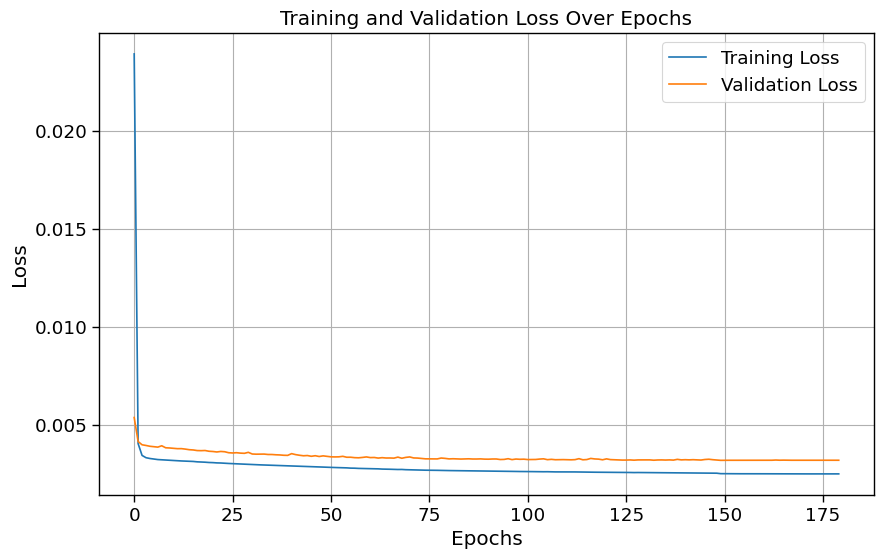

In [359]:

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [320]:
print(f"Shape of trainPredict before inverse transform: {trainPredict.shape}")
print(f"Shape of testPredict before inverse transform: {testPredict.shape}")


Shape of trainPredict before inverse transform: (132552, 1)
Shape of testPredict before inverse transform: (44164, 1)


In [13]:
# Step 5: Make Predictions

# Save the entire model
# torch.save(model, "/kaggle/working/best_model.pth")
# print("model saved")

model = torch.load("/kaggle/working/best_model.pth")

# model = best_model
model.eval()
with torch.no_grad():
    trainPredict = model(trainX).cpu().numpy()  # Move back to CPU for NumPy operations
    testPredict = model(testX).cpu().numpy()


/tmp/ipykernel_23/3500671853.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/kaggle/working/best_model.pth")


AttributeError: 'LSTMModel' object has no attribute 'n_layers'

In [362]:
print(f"Dataset shape: {dataset.shape}")  # Full dataset shape
print(f"TrainY shape: {trainY.shape}")    # Target values for training


Dataset shape: (176777, 30)
TrainY shape: torch.Size([132552])


## TEst test


/tmp/ipykernel_23/1061067366.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainX_tensor = torch.tensor(trainX, dtype=torch.float32).to(device)
/tmp/ipykernel_23/1061067366.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testX_tensor = torch.tensor(testX, dtype=torch.float32).to(device)


Train Metrics:
 - Mean Absolute Error (MAE): 4139.3033
 - Root Mean Squared Error (RMSE): 5499.4831
 - R-Squared (R²): 0.7839
Test Metrics:
 - Mean Absolute Error (MAE): 4381.4607
 - Root Mean Squared Error (RMSE): 5943.6512
 - R-Squared (R²): 0.7557


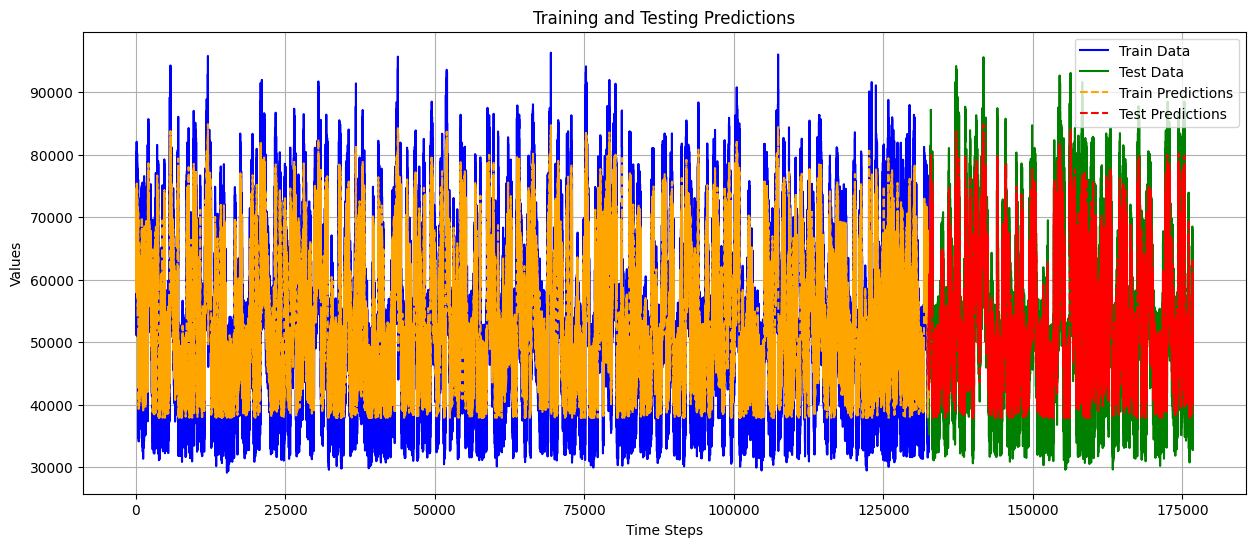

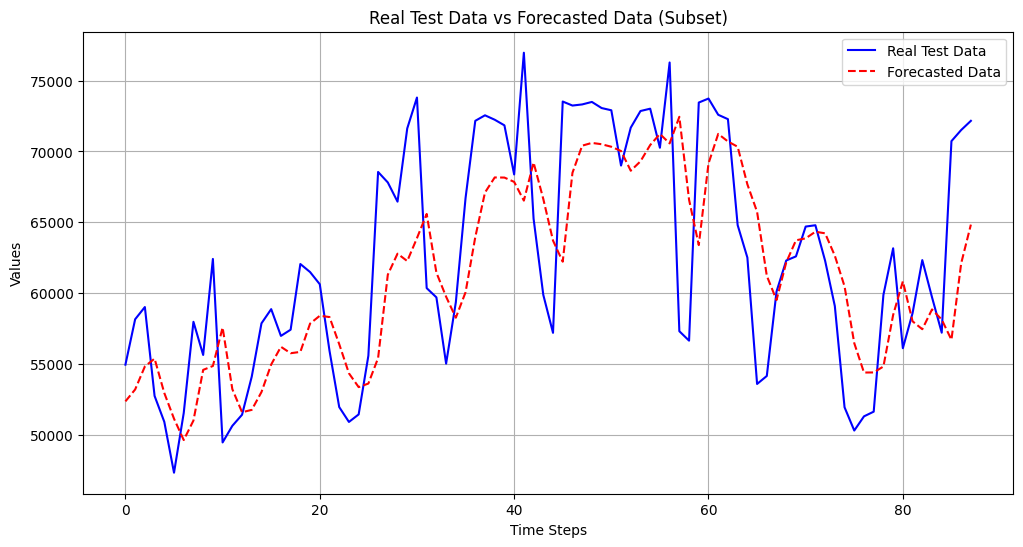

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("/kaggle/working/best_lstm_model.pth")
# model = model.to(device)
model.eval()

# Convert data to tensors and move to the GPU/CPU
trainX_tensor = torch.tensor(trainX, dtype=torch.float32).to(device)
testX_tensor = torch.tensor(testX, dtype=torch.float32).to(device)

# Make predictions
with torch.no_grad():
    train_predictions = model(trainX_tensor).squeeze().cpu().numpy()  # Move back to CPU
    test_predictions = model(testX_tensor).squeeze().cpu().numpy()   # Move back to CPU

# Expand data for inverse scaling
trainY_expanded = np.zeros((trainY.shape[0], dataset.shape[1]))
trainY_expanded[:, 0] = trainY.cpu().numpy()  # Move trainY to CPU and convert to NumPy

testY_expanded = np.zeros((testY.shape[0], dataset.shape[1]))
testY_expanded[:, 0] = testY.cpu().numpy()  # Move testY to CPU and convert to NumPy

train_predictions_expanded = np.zeros((train_predictions.shape[0], dataset.shape[1]))
train_predictions_expanded[:, 0] = train_predictions  # train_predictions is already a NumPy array

test_predictions_expanded = np.zeros((test_predictions.shape[0], dataset.shape[1]))
test_predictions_expanded[:, 0] = test_predictions  # test_predictions is already a NumPy array

# Perform inverse transformations
trainY_original = scaler.inverse_transform(trainY_expanded)[:, 0]
testY_original = scaler.inverse_transform(testY_expanded)[:, 0]
train_predictions_original = scaler.inverse_transform(train_predictions_expanded)[:, 0]
test_predictions_original = scaler.inverse_transform(test_predictions_expanded)[:, 0]

# Continue with the rest of the code for evaluation and plotting...

# Perform inverse transformations
trainY_original = scaler.inverse_transform(trainY_expanded)[:, 0]
testY_original = scaler.inverse_transform(testY_expanded)[:, 0]
train_predictions_original = scaler.inverse_transform(train_predictions_expanded)[:, 0]
test_predictions_original = scaler.inverse_transform(test_predictions_expanded)[:, 0]

# Calculate Metrics
mae_train = mean_absolute_error(trainY_original, train_predictions_original)
rmse_train = np.sqrt(mean_squared_error(trainY_original, train_predictions_original))
r2_train = r2_score(trainY_original, train_predictions_original)

mae_test = mean_absolute_error(testY_original, test_predictions_original)
rmse_test = np.sqrt(mean_squared_error(testY_original, test_predictions_original))
r2_test = r2_score(testY_original, test_predictions_original)

print(f"Train Metrics:")
print(f" - Mean Absolute Error (MAE): {mae_train:.4f}")
print(f" - Root Mean Squared Error (RMSE): {rmse_train:.4f}")
print(f" - R-Squared (R²): {r2_train:.4f}")

print(f"Test Metrics:")
print(f" - Mean Absolute Error (MAE): {mae_test:.4f}")
print(f" - Root Mean Squared Error (RMSE): {rmse_test:.4f}")
print(f" - R-Squared (R²): {r2_test:.4f}")

# Plot full training and testing predictions
plt.figure(figsize=(15, 6))
plt.plot(trainY_original, label='Train Data', color='blue')
plt.plot(range(len(trainY_original), len(trainY_original) + len(testY_original)), testY_original, label='Test Data', color='green')
plt.plot(train_predictions_original, label='Train Predictions', linestyle='--', color='orange')
plt.plot(range(len(trainY_original), len(trainY_original) + len(test_predictions_original)), test_predictions_original, label='Test Predictions', linestyle='--', color='red')
plt.legend()
plt.title("Training and Testing Predictions")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.grid()
plt.show()

# Plot subset of test predictions (e.g., 5% of test data with a shifting window)
percentage_to_plot = 0.002  # 5% of test data
shift = 200  # Adjust the starting index of the subset
subset_size = int(len(testY_original) * percentage_to_plot)

original_test_values_subset = testY_original[shift:shift + subset_size]
test_predictions_subset = test_predictions_original[shift:shift + subset_size]

plt.figure(figsize=(12, 6))
plt.plot(original_test_values_subset, label='Real Test Data', color='blue')
plt.plot(test_predictions_subset, label='Forecasted Data', linestyle='--', color='red')
plt.legend()
plt.title("Real Test Data vs Forecasted Data (Subset)")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.grid()
plt.show()


In [63]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# # Load and preprocess the data
# # Assuming dataset[:, 0] is the target series
# time = np.arange(len(dataset))  # Time steps

# # Step 1: Fit a Polynomial Trend
# degree = 2  # Degree of the polynomial
# coefficients = np.polyfit(time, dataset[:, 0], degree)
# polynomial = np.poly1d(coefficients)
# trend = polynomial(time)

# # Step 2: Detrend the Series
# residuals = dataset[:, 0] - trend

# # Step 3: Create Sequences for LSTM
# def create_sequences(data, lookback):
#     X, Y = [], []
#     for i in range(len(data) - lookback):
#         X.append(data[i:i + lookback])
#         Y.append(data[i + lookback])
#     return np.array(X), np.array(Y)

# lookback = 10  # Number of time steps to look back
# batch_size = 64  # Batch size

# # Train-test split
# train_size = int(len(residuals) * 0.75)
# train_residuals = residuals[:train_size]
# test_residuals = residuals[train_size:]

# trainX, trainY = create_sequences(train_residuals, lookback)
# testX, testY = create_sequences(test_residuals, lookback)

# # Reshape for LSTM: [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], lookback, 1))
# testX = np.reshape(testX, (testX.shape[0], lookback, 1))

# # Convert to tensors
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# trainX_tensor = torch.tensor(trainX, dtype=torch.float32)
# trainY_tensor = torch.tensor(trainY, dtype=torch.float32)
# testX_tensor = torch.tensor(testX, dtype=torch.float32)
# testY_tensor = torch.tensor(testY, dtype=torch.float32)

# # Create DataLoaders for batching
# train_dataset = TensorDataset(trainX_tensor, trainY_tensor)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test_dataset = TensorDataset(testX_tensor, testY_tensor)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Step 4: Define the LSTM Model
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers):
#         super(LSTMModel, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         _, (hn, _) = self.lstm(x)  # Last hidden state
#         out = self.fc(hn[-1])
#         return out

# # Initialize model, loss, and optimizer
# model = LSTMModel(input_size=1, hidden_size=50, num_layers=2).to(device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Step 5: Train the Model
# epochs = 50
# for epoch in range(epochs):
#     model.train()
#     train_loss = 0.0
#     for batch_X, batch_Y in train_loader:
#         batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

#         optimizer.zero_grad()
#         outputs = model(batch_X)
#         loss = criterion(outputs.squeeze(), batch_Y)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#     # Validation loss
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for batch_X, batch_Y in test_loader:
#             batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
#             val_outputs = model(batch_X)
#             val_loss += criterion(val_outputs.squeeze(), batch_Y).item()

#     print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.6f}, Validation Loss: {val_loss/len(test_loader):.6f}")

# # Step 6: Make Predictions
# model.eval()
# with torch.no_grad():
#     train_predictions = []
#     for batch_X, _ in train_loader:
#         batch_X = batch_X.to(device)
#         batch_preds = model(batch_X).cpu().numpy()
#         train_predictions.extend(batch_preds)

#     test_predictions = []
#     for batch_X, _ in test_loader:
#         batch_X = batch_X.to(device)
#         batch_preds = model(batch_X).cpu().numpy()
#         test_predictions.extend(batch_preds)

# Flatten predictions
train_predictions = np.array(train_predictions).flatten()
test_predictions = np.array(test_predictions).flatten()

# Add trend back
train_predictions_with_trend = train_predictions + trend[lookback:train_size]
test_predictions_with_trend = test_predictions + trend[train_size + lookback:]

# Step 7: Evaluate and Plot
train_actual = dataset[lookback:train_size, 0]
test_actual = dataset[train_size + lookback:, 0]

# Metrics
mae = mean_absolute_error(test_actual, test_predictions_with_trend)
rmse = np.sqrt(mean_squared_error(test_actual, test_predictions_with_trend))
r2 = r2_score(test_actual, test_predictions_with_trend)

print(f"Test MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(train_actual, label='Train Actual', color='blue')
plt.plot(train_predictions_with_trend, label='Train Predictions', linestyle='--', color='orange')
plt.plot(test_actual, label='Test Actual', color='green')
plt.plot(test_predictions_with_trend, label='Test Predictions', linestyle='--', color='red')
plt.legend()
plt.title("Detrended LSTM Predictions with Retrending")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.grid()
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [44185, 44174]

## Fin TEst TEst

In [19]:
# Create zero arrays for trainY and testY
trainY_expanded = np.zeros((trainY.shape[0], dataset.shape[1]))  # Match dataset columns
trainY_expanded[:, 0] = trainY.cpu().numpy()  # Place trainY in the first column

testY_expanded = np.zeros((testY.shape[0], dataset.shape[1]))  # Match dataset columns
testY_expanded[:, 0] = testY.cpu().numpy()  # Place testY in the first column

# Perform inverse transformation
trainY_original = scaler.inverse_transform(trainY_expanded)[:, 0]  # Extract first column
testY_original = scaler.inverse_transform(testY_expanded)[:, 0]  # Extract first column



# Expand predictions
trainPredict_expanded = np.zeros((trainPredict.shape[0], dataset.shape[1]))
trainPredict_expanded[:, 0] = trainPredict[:, 0]

testPredict_expanded = np.zeros((testPredict.shape[0], dataset.shape[1]))
testPredict_expanded[:, 0] = testPredict[:, 0]

# Perform inverse transformation
trainPredict_original = scaler.inverse_transform(trainPredict_expanded)[:, 0]
testPredict_original = scaler.inverse_transform(testPredict_expanded)[:, 0]

print(f"trainY_original shape: {trainY_original.shape}")  # Should match (123733,)
print(f"testY_original shape: {testY_original.shape}")    # Should match (53024,)
print(f"trainPredict_original shape: {trainPredict_original.shape}")
print(f"testPredict_original shape: {testPredict_original.shape}")



# Step 6: Calculate Errors
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate metrics
print('Mean Absolute Error Train:', mean_absolute_error(trainY_original, trainPredict_original))
print('Mean Squared Error Train:', np.sqrt(mean_squared_error(trainY_original, trainPredict_original)))

print('Mean Absolute Error Test:', mean_absolute_error(testY_original, testPredict_original))
print('Mean Squared Error Test:', np.sqrt(mean_squared_error(testY_original, testPredict_original)))


NameError: name 'trainPredict' is not defined

In [364]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Step 6: Calculate Errors and Metrics
mae_train = mean_absolute_error(trainY_original, trainPredict_original)
rmse_train = np.sqrt(mean_squared_error(trainY_original, trainPredict_original))
r2_train = r2_score(trainY_original, trainPredict_original)

mae_test = mean_absolute_error(testY_original, testPredict_original)
rmse_test = np.sqrt(mean_squared_error(testY_original, testPredict_original))
r2_test = r2_score(testY_original, testPredict_original)

# Print results
print(f"Train Metrics:")
print(f" - Mean Absolute Error (MAE): {mae_train:.4f}")
print(f" - Root Mean Squared Error (RMSE): {rmse_train:.4f}")
print(f" - R-Squared (R2): {r2_train:.4f}")

print(f"Test Metrics:")
print(f" - Mean Absolute Error (MAE): {mae_test:.4f}")
print(f" - Root Mean Squared Error (RMSE): {rmse_test:.4f}")
print(f" - R-Squared (R2): {r2_test:.4f}")


Train Metrics:
 - Mean Absolute Error (MAE): 3405.7719
 - Root Mean Squared Error (RMSE): 4731.8531
 - R-Squared (R2): 0.8400
Test Metrics:
 - Mean Absolute Error (MAE): 3699.2751
 - Root Mean Squared Error (RMSE): 5353.9007
 - R-Squared (R2): 0.8018


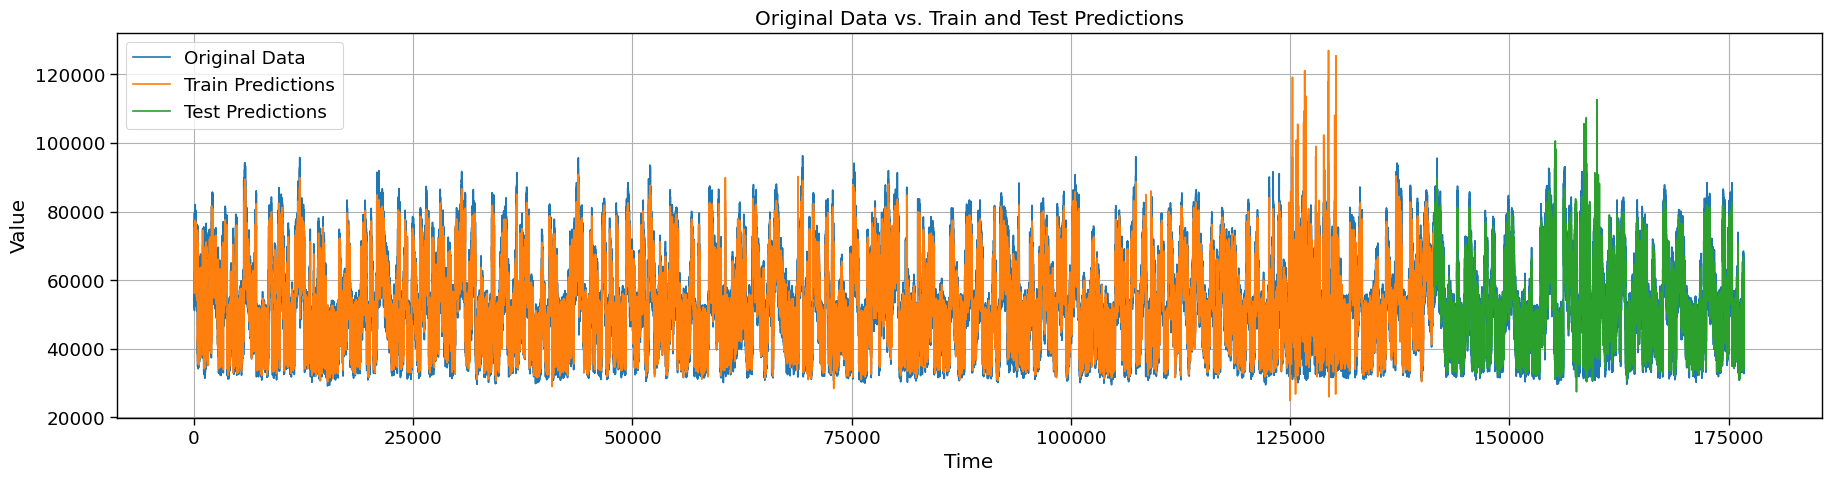

In [365]:
# Expand dataset[:, 0:1] to match the scaler's expected input shape
expanded_dataset = np.zeros_like(dataset)
expanded_dataset[:, 0:1] = dataset[:, 0:1]

# Perform inverse transform and extract the first column
original_data = scaler.inverse_transform(expanded_dataset)[:, 0]


# Expand dataset and inverse transform to get the original target variable
expanded_dataset = np.zeros_like(dataset)
expanded_dataset[:, 0:1] = dataset[:, 0:1]
original_data = scaler.inverse_transform(expanded_dataset)[:, 0]

# Plot the results
plt.figure(figsize=(22, 5))
plt.plot(original_data, label='Original Data')  # Original target variable
plt.plot(trainPredictPlot, label='Train Predictions')  # Training predictions
plt.plot(testPredictPlot, label='Test Predictions')  # Testing predictions
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Original Data vs. Train and Test Predictions')
plt.legend()
plt.grid()
plt.show()


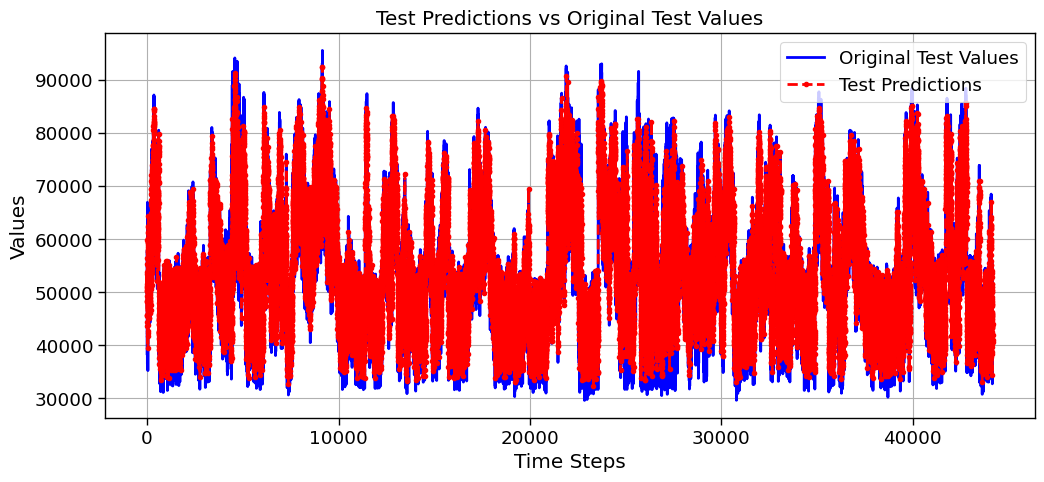

In [366]:
# Expand dataset and inverse transform to retrieve original test values
expanded_dataset = np.zeros_like(dataset)
expanded_dataset[:, 0:1] = dataset[:, 0:1]  # Retain only the first column for the target variable
original_data = scaler.inverse_transform(expanded_dataset)[:, 0]  # Inverse transform and extract the first column

# Define the range of test data in the original dataset
test_start_index = len(trainPredict_original) + (look_back * 2)
test_end_index = test_start_index + len(testPredict_original)

# Extract corresponding original values from the dataset
original_test_values = original_data[test_start_index:test_end_index]

# Ensure test predictions are reshaped properly for plotting
test_predictions_to_plot = testPredict_original.reshape(-1)

# Plot original test values and test predictions
plt.figure(figsize=(12, 5))
plt.plot(original_test_values, label='Original Test Values', color='blue', linewidth=2)
plt.plot(test_predictions_to_plot, label='Test Predictions', color='red', linestyle='--', linewidth=2, marker='o', markersize=3)
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Test Predictions vs Original Test Values')
plt.legend()
plt.grid()
plt.show()


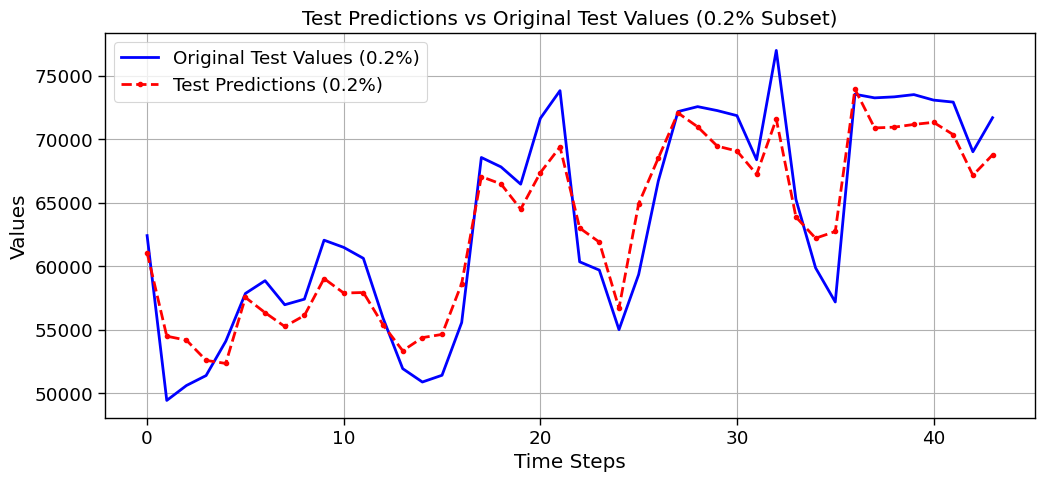

In [368]:
# Define the percentage to plot
percentage_to_plot = 0.001# 0.2%

# Calculate the range for plotting
num_points = int(len(original_test_values) * percentage_to_plot)
start_index = 200  # You can adjust this to focus on different parts of the signal
end_index = start_index + num_points

# Subset the original test values and predictions
original_test_values_subset = original_test_values[start_index:end_index]
test_predictions_subset = test_predictions_to_plot[start_index:end_index]

# Plot the subset of the signal
plt.figure(figsize=(12, 5))
plt.plot(original_test_values_subset, label='Original Test Values (0.2%)', color='blue', linewidth=2)
plt.plot(test_predictions_subset, label='Test Predictions (0.2%)', color='red', linestyle='--', linewidth=2, marker='o', markersize=3)
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title('Test Predictions vs Original Test Values (0.2% Subset)')
plt.legend()
plt.grid()
plt.show()


### CNN-LSTM

In [32]:
# Step 2: Prepare Data
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(f"First few normalized training targets: {trainY[:5]}")
print(f"First few normalized validation targets: {testY[:5]}")

# Reshape input to be [samples, features, time steps] for CNN input
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))  # Shape: [samples, channels, look_back]
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))      # Shape: [samples, channels, look_back]

# Convert data to PyTorch tensors and move to GPU if available
trainX_tensor = torch.tensor(trainX, dtype=torch.float32).to(device)
trainY_tensor = torch.tensor(trainY, dtype=torch.float32).to(device)
testX_tensor = torch.tensor(testX, dtype=torch.float32).to(device)
testY_tensor = torch.tensor(testY, dtype=torch.float32).to(device)


First few normalized training targets: [0.65923035 0.6548073  0.62104607 0.59073985 0.5758772 ]
First few normalized validation targets: [0.3021088  0.35333887 0.24468341 0.33597425 0.26885387]


In [38]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, cnn_filters=32, kernel_size=3, hidden_size=50, n_lstm_layers=1):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=cnn_filters, kernel_size=kernel_size, stride=1)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool1d(kernel_size=2)
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=cnn_filters, hidden_size=hidden_size, num_layers=n_lstm_layers, batch_first=True)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 100),
            nn.ReLU(),
            nn.Linear(100, 60),
            nn.ReLU(),
            nn.Linear(60, 50),
            nn.ReLU(),
            nn.Linear(50, 1)  # Output layer
        )
    
    def forward(self, x):
        # Input shape: [batch_size, channels, time_steps]
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.transpose(1, 2)  # Swap dimensions for LSTM [batch_size, time_steps, channels]
        
        # LSTM
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])  # Use the last hidden state
        return out

# Initialize model
input_size = look_back  # Time steps
cnn_filters = 32
kernel_size = 3
hidden_size = 30
n_lstm_layers = 1

model = CNNLSTMModel(input_size=input_size, cnn_filters=cnn_filters, kernel_size=kernel_size, hidden_size=hidden_size, n_lstm_layers=n_lstm_layers).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [85]:
import matplotlib.pyplot as plt

# Training loop
epochs = 50
batch_size = 132
best_val_loss = 1e9
train_losses = []
val_losses = []

# Data loaders
train_dataset = torch.utils.data.TensorDataset(trainX_tensor, trainY_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = torch.utils.data.TensorDataset(testX_tensor, testY_tensor)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    # Store losses
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "/kaggle/working/cnn_lstm_model2.pth")
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.6f}, Validation Loss: {val_losses[-1]:.6f}")

print("Model saved as 'cnn_lstm_model2.pth'")



Epoch 1/50, Train Loss: 0.008668, Validation Loss: 0.007403
Epoch 2/50, Train Loss: 0.006264, Validation Loss: 0.006931
Epoch 3/50, Train Loss: 0.005994, Validation Loss: 0.006759
Epoch 4/50, Train Loss: 0.005884, Validation Loss: 0.006805
Epoch 5/50, Train Loss: 0.005802, Validation Loss: 0.006642
Epoch 6/50, Train Loss: 0.005716, Validation Loss: 0.006597
Epoch 7/50, Train Loss: 0.005628, Validation Loss: 0.006460
Epoch 8/50, Train Loss: 0.005568, Validation Loss: 0.006367
Epoch 9/50, Train Loss: 0.005521, Validation Loss: 0.006356
Epoch 10/50, Train Loss: 0.005486, Validation Loss: 0.006344
Epoch 11/50, Train Loss: 0.005474, Validation Loss: 0.006401
Epoch 12/50, Train Loss: 0.005424, Validation Loss: 0.006241
Epoch 13/50, Train Loss: 0.005413, Validation Loss: 0.006200
Epoch 14/50, Train Loss: 0.005396, Validation Loss: 0.006341
Epoch 15/50, Train Loss: 0.005348, Validation Loss: 0.006499
Epoch 16/50, Train Loss: 0.005330, Validation Loss: 0.006197
Epoch 17/50, Train Loss: 0.005307

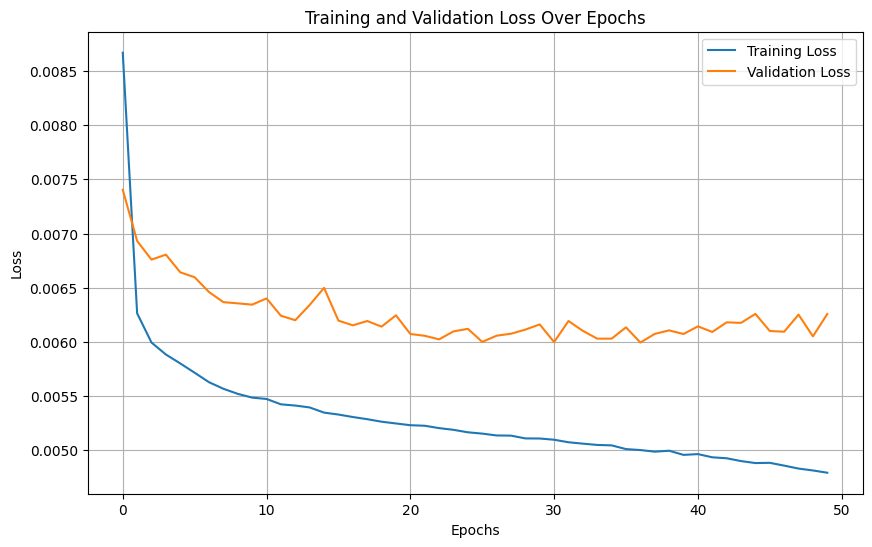

In [86]:
# Plot losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()


## TEst TEst

/tmp/ipykernel_23/3242054529.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_lstm_model.pth", map_location=device))


Train Metrics:
 - Mean Absolute Error (MAE): 3403.9675
 - Root Mean Squared Error (RMSE): 4703.4922
 - R-Squared (R²): 0.8420
Test Metrics:
 - Mean Absolute Error (MAE): 3661.1244
 - Root Mean Squared Error (RMSE): 5185.4603
 - R-Squared (R²): 0.8141


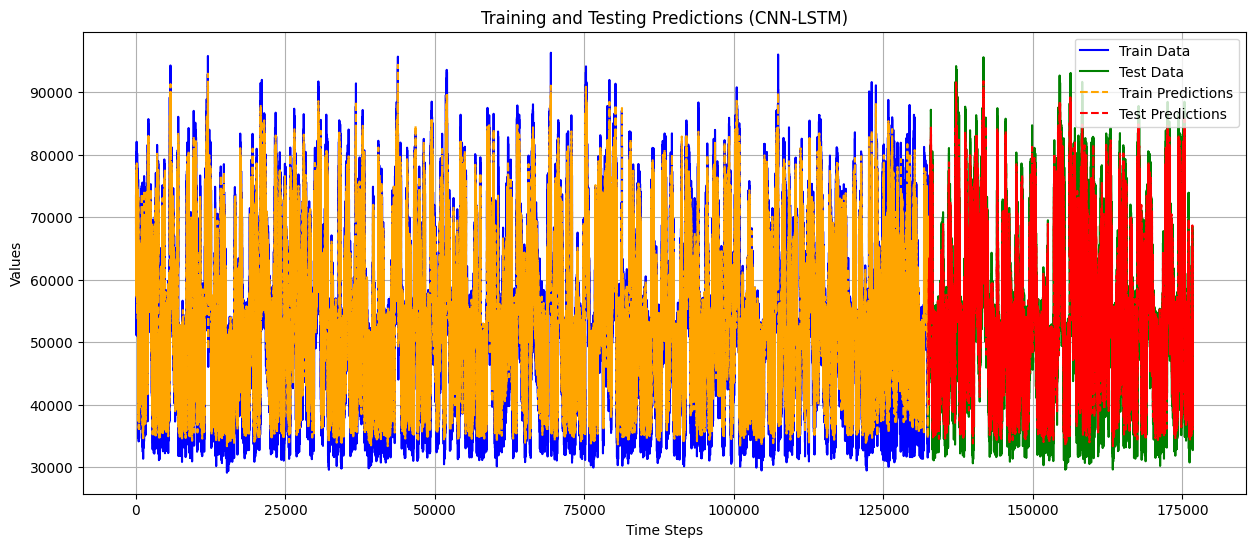

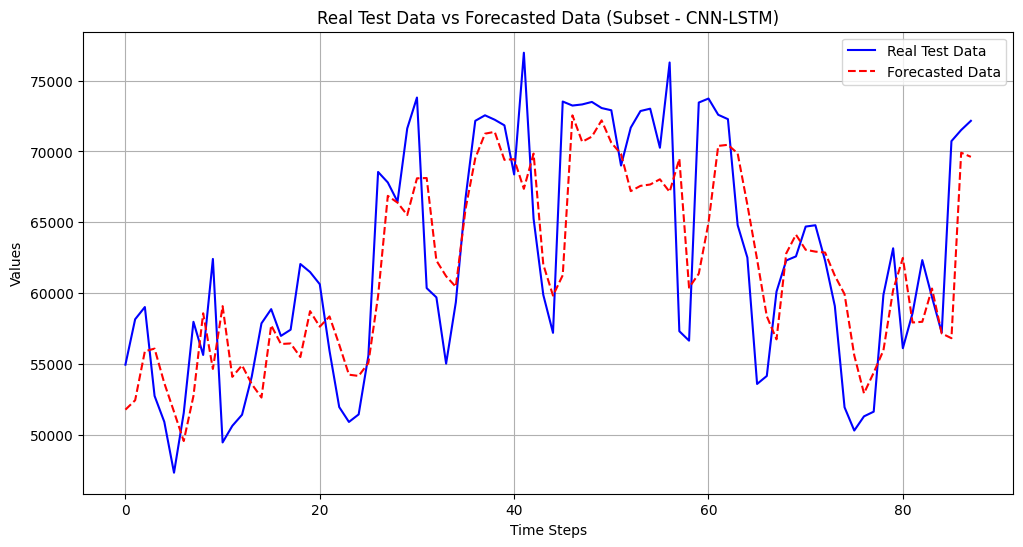

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure model is loaded on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("cnn_lstm_model.pth", map_location=device))
# model.load_state_dict(torch.load("/kaggle/working/cnn_lstm_model.pth"))
model = model.to(device)
model.eval()

# Convert test data to tensors and move to GPU/CPU
trainX_tensor = torch.tensor(trainX, dtype=torch.float32).to(device)
testX_tensor = torch.tensor(testX, dtype=torch.float32).to(device)

# Make predictions
with torch.no_grad():
    train_predictions = model(trainX_tensor).squeeze().cpu().numpy()  # Move back to CPU
    test_predictions = model(testX_tensor).squeeze().cpu().numpy()   # Move back to CPU

# Expand original Y for inverse transformation
trainY_expanded = np.zeros((trainY.shape[0], dataset.shape[1]))  # Create empty arrays for full feature space
# Ensure trainY and testY are NumPy arrays
if isinstance(trainY, torch.Tensor):
    trainY_expanded[:, 0] = trainY.cpu().numpy()
else:
    trainY_expanded[:, 0] = trainY  # If it's already a NumPy array, use it directly


testY_expanded = np.zeros((testY.shape[0], dataset.shape[1]))
if isinstance(testY, torch.Tensor):
    testY_expanded[:, 0] = testY.cpu().numpy()
else:
    testY_expanded[:, 0] = testY  # If it's already a NumPy array, use it directly

# Ensure trainY is a NumPy array
# if isinstance(trainY, torch.Tensor):
#     trainY_expanded[:, 0] = trainY.cpu().numpy()
# else:
#     trainY_expanded[:, 0] = trainY  # If it's already a NumPy array, use it directly

# # Repeat the same for testY
# if isinstance(testY, torch.Tensor):
#     testY_expanded[:, 0] = testY.cpu().numpy()
# else:
#     testY_expanded[:, 0] = testY

# Expand predictions for inverse scaling
train_predictions_expanded = np.zeros((train_predictions.shape[0], dataset.shape[1]))
train_predictions_expanded[:, 0] = train_predictions

test_predictions_expanded = np.zeros((test_predictions.shape[0], dataset.shape[1]))
test_predictions_expanded[:, 0] = test_predictions

# Perform inverse transformations
trainY_original = scaler.inverse_transform(trainY_expanded)[:, 0]
testY_original = scaler.inverse_transform(testY_expanded)[:, 0]
train_predictions_original = scaler.inverse_transform(train_predictions_expanded)[:, 0]
test_predictions_original = scaler.inverse_transform(test_predictions_expanded)[:, 0]

# Calculate Metrics
mae_train = mean_absolute_error(trainY_original, train_predictions_original)
rmse_train = np.sqrt(mean_squared_error(trainY_original, train_predictions_original))
r2_train = r2_score(trainY_original, train_predictions_original)

mae_test = mean_absolute_error(testY_original, test_predictions_original)
rmse_test = np.sqrt(mean_squared_error(testY_original, test_predictions_original))
r2_test = r2_score(testY_original, test_predictions_original)

# Print Metrics
print(f"Train Metrics:")
print(f" - Mean Absolute Error (MAE): {mae_train:.4f}")
print(f" - Root Mean Squared Error (RMSE): {rmse_train:.4f}")
print(f" - R-Squared (R²): {r2_train:.4f}")

print(f"Test Metrics:")
print(f" - Mean Absolute Error (MAE): {mae_test:.4f}")
print(f" - Root Mean Squared Error (RMSE): {rmse_test:.4f}")
print(f" - R-Squared (R²): {r2_test:.4f}")

# Plot full training and testing predictions
plt.figure(figsize=(15, 6))
plt.plot(trainY_original, label='Train Data', color='blue')
plt.plot(range(len(trainY_original), len(trainY_original) + len(testY_original)), testY_original, label='Test Data', color='green')
plt.plot(train_predictions_original, label='Train Predictions', linestyle='--', color='orange')
plt.plot(range(len(trainY_original), len(trainY_original) + len(test_predictions_original)), test_predictions_original, label='Test Predictions', linestyle='--', color='red')
plt.legend()
plt.title("Training and Testing Predictions (CNN-LSTM)")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.grid()
plt.show()

# Plot subset of test predictions with shifting window
percentage_to_plot = 0.002  # 5% of test data
shift = 200  # Adjust the starting index for the subset
subset_size = int(len(testY_original) * percentage_to_plot)

original_test_values_subset = testY_original[shift:shift + subset_size]
test_predictions_subset = test_predictions_original[shift:shift + subset_size]

plt.figure(figsize=(12, 6))
plt.plot(original_test_values_subset, label='Real Test Data', color='blue')
plt.plot(test_predictions_subset, label='Forecasted Data', linestyle='--', color='red')
plt.legend()
plt.title("Real Test Data vs Forecasted Data (Subset - CNN-LSTM)")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.grid()
plt.show()


## End TEst Test

In [59]:
# Load model weights
model.load_state_dict(torch.load("/kaggle/working/cnn_lstm_model.pth"))
print("Model loaded successfully!")


Model loaded successfully!


/tmp/ipykernel_23/1560329690.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/cnn_lstm_model.pth"))


In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate the model on test data
model.eval()
with torch.no_grad():
    train_predictions = model(trainX_tensor).squeeze().cpu().numpy()
    test_predictions = model(testX_tensor).squeeze().cpu().numpy()

# Expand data for inverse transform
trainY_expanded = np.zeros((trainY.shape[0], dataset.shape[1]))
trainY_expanded[:, 0] = trainY  # No .cpu().numpy() since trainY is already a NumPy array

testY_expanded = np.zeros((testY.shape[0], dataset.shape[1]))
testY_expanded[:, 0] = testY  # No .cpu().numpy()

train_predictions_expanded = np.zeros((train_predictions.shape[0], dataset.shape[1]))
train_predictions_expanded[:, 0] = train_predictions

test_predictions_expanded = np.zeros((test_predictions.shape[0], dataset.shape[1]))
test_predictions_expanded[:, 0] = test_predictions

# Perform inverse transformations
trainY_original = scaler.inverse_transform(trainY_expanded)[:, 0]
testY_original = scaler.inverse_transform(testY_expanded)[:, 0]
train_predictions_original = scaler.inverse_transform(train_predictions_expanded)[:, 0]
test_predictions_original = scaler.inverse_transform(test_predictions_expanded)[:, 0]

# Calculate metrics
mae_train = mean_absolute_error(trainY_original, train_predictions_original)
mse_train = mean_squared_error(trainY_original, train_predictions_original)
rmse_train = np.sqrt(mean_squared_error(trainY_original, train_predictions_original))
r2_train = r2_score(trainY_original, train_predictions_original)

mae_test = mean_absolute_error(testY_original, test_predictions_original)
mse_test = mean_squared_error(testY_original, test_predictions_original)
rmse_test = np.sqrt(mean_squared_error(testY_original, test_predictions_original))
r2_test = r2_score(testY_original, test_predictions_original)

print(f"Train Metrics:")
print(f" - Mean Absolute Error (MAE): {mae_train:.4f}")
print(f" - Mean Squared Error (MSE): {mse_train:.4f}")
print(f" - Root Mean Squared Error (RMSE): {rmse_train:.4f}")
print(f" - R-Squared (R²): {r2_train:.4f}")

print(f"Test Metrics:")
print(f" - Mean Absolute Error (MAE): {mae_test:.4f}")
print(f" - Mean Squared Error (MSE): {mse_test:.4f}")
print(f" - Root Mean Squared Error (RMSE): {rmse_test:.4f}")
print(f" - R-Squared (R²): {r2_test:.4f}")





Train Metrics:
 - Mean Absolute Error (MAE): 3379.8734
 - Mean Squared Error (MSE): 22300729.2153
 - Root Mean Squared Error (RMSE): 4722.3648
 - R-Squared (R²): 0.8407
Test Metrics:
 - Mean Absolute Error (MAE): 3647.8420
 - Mean Squared Error (MSE): 27751779.9239
 - Root Mean Squared Error (RMSE): 5267.9958
 - R-Squared (R²): 0.8081


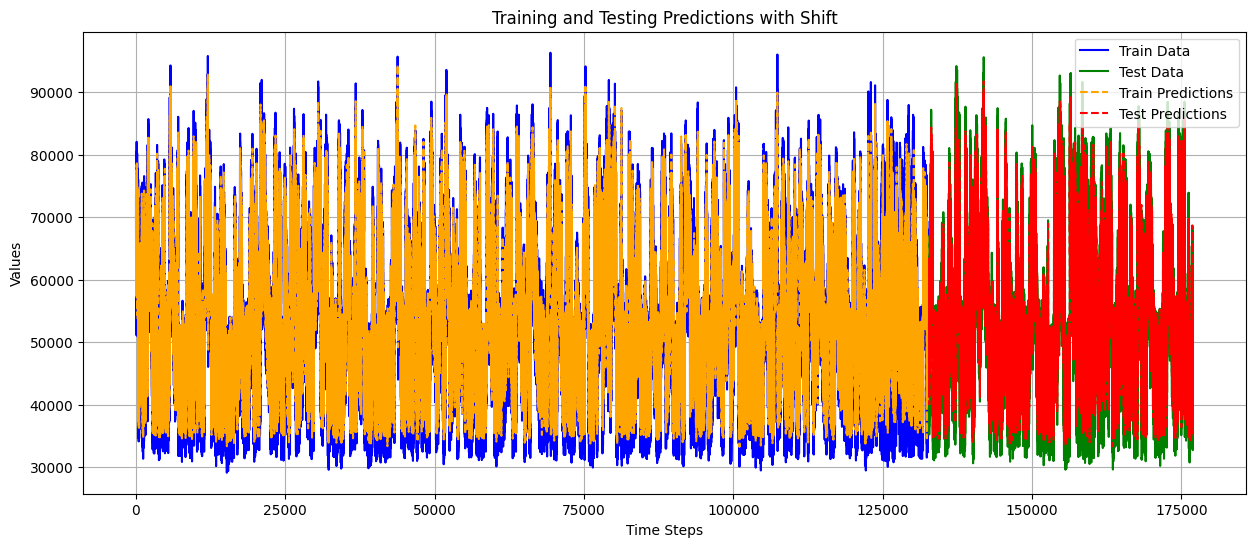

In [69]:
# Define the shifting value
shift = 200

# Plot full training and testing predictions with shifting
plt.figure(figsize=(15, 6))
plt.plot(trainY_original, label='Train Data', color='blue')
plt.plot(range(len(trainY_original) + shift, len(trainY_original) + shift + len(testY_original)),
         testY_original, label='Test Data', color='green')
plt.plot(train_predictions_original, label='Train Predictions', linestyle='--', color='orange')

plt.plot(range(len(trainY_original) + shift, len(trainY_original) + shift + len(test_predictions_original)),
         test_predictions_original, label='Test Predictions', linestyle='--', color='red')

plt.legend()
plt.title("Training and Testing Predictions with Shift")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.grid()
plt.show()

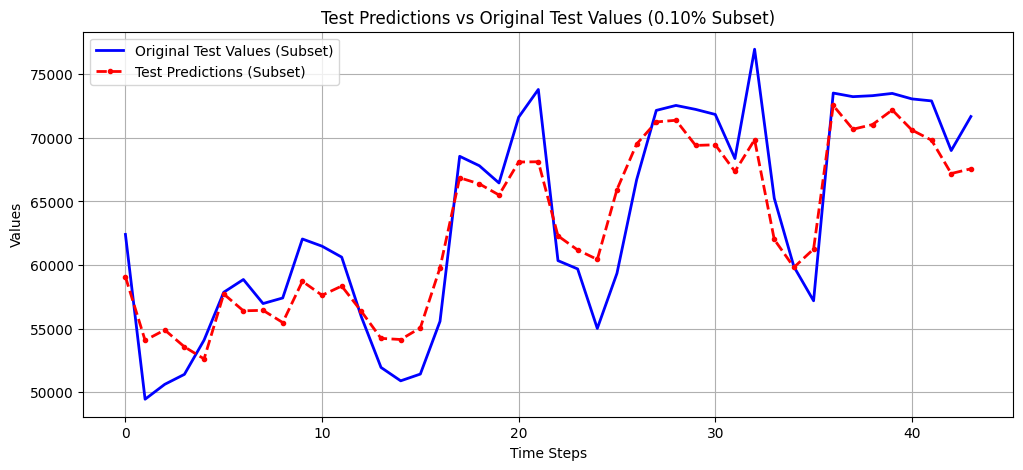

Test Metrics:
 - Mean Absolute Error (MAE): 2737.4973
 - Root Mean Squared Error (RMSE): 4439.8525
 - R-Squared (R²): 0.8637


In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the range of test data in the original dataset
test_start_index = len(train_predictions_original) + (look_back * 2)
test_end_index = test_start_index + len(test_predictions_original)

# Prepare a full array for inverse transformation
dataset_expanded = np.zeros_like(dataset)  # Same shape as original dataset
dataset_expanded[:, 0] = dataset[:, 0]    # Only the first column contains the scaled data to be inverse transformed

# Perform inverse transformation
dataset_original = scaler.inverse_transform(dataset_expanded)

# Extract the original test values
original_test_values = dataset_original[test_start_index:test_end_index, 0]  # Extract only the first column

# Define the percentage to plot and the shifting parameters
percentage_to_plot = 0.001  # 0.1% of the test data
# start_index = 1510  
start_index = 210
num_points = int(len(original_test_values) * percentage_to_plot)
end_index = start_index + num_points

# Ensure indices are within bounds
if end_index > len(original_test_values):
    end_index = len(original_test_values)

# Subset the original test values and predictions
original_test_values_subset = original_test_values[start_index:end_index]
test_predictions_subset = test_predictions_original[start_index:end_index]

# Plot the subset of the signal
plt.figure(figsize=(12, 5))
plt.plot(original_test_values_subset, label='Original Test Values (Subset)', color='blue', linewidth=2)
plt.plot(test_predictions_subset, label='Test Predictions (Subset)', color='red', linestyle='--', linewidth=2, marker='o', markersize=3)
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.title(f'Test Predictions vs Original Test Values ({percentage_to_plot*100:.2f}% Subset)')
plt.legend()
plt.grid()
plt.show()

# Evaluate metrics for the whole test set
mae_test = mean_absolute_error(original_test_values, test_predictions_original)
rmse_test = np.sqrt(mean_squared_error(original_test_values, test_predictions_original))
r2_test = r2_score(original_test_values, test_predictions_original)

print(f"Test Metrics:")
print(f" - Mean Absolute Error (MAE): {mae_test:.4f}")
print(f" - Root Mean Squared Error (RMSE): {rmse_test:.4f}")
print(f" - R-Squared (R²): {r2_test:.4f}")
